In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def hinge_loss(predictions, desired_class=0):
    """
    Compute hinge loss for counterfactual generation
    Ensures zero penalty when predictions are already in the desired class
    """
    # For desired class 0, we want predictions to be below 0.5
    if desired_class == 0:
        # Compute logits (inverse of sigmoid)
        logits = -torch.log(1/predictions - 1)
        # Returns zero when prediction is already below 0.5 (logit < 0)
        return torch.max(torch.zeros_like(logits), 1 + logits)
    else:
        # Compute logits
        logits = -torch.log(1/predictions - 1)
        # Returns zero when prediction is already above 0.5 (logit > 0)
        return torch.max(torch.zeros_like(logits), 1 - logits)

def compute_l1_distance(x1, x2):
    """Compute L1 distance between two tensors"""
    return torch.abs(x1 - x2).sum(dim=1, keepdim=True)

def compute_dpp_diversity(counterfactuals, epsilon=1e-6):
    """
    Compute determinantal point process diversity
    K_ij = 1 / (1 + dist(ci, cj)) where dist is L1 distance
    """
    batch_size, num_cfs, num_features = counterfactuals.shape
    
    # Compute pairwise L1 distances for all counterfactuals in batch
    # Reshape for broadcasting
    cfs_expanded1 = counterfactuals.view(batch_size, num_cfs, 1, num_features)
    cfs_expanded2 = counterfactuals.view(batch_size, 1, num_cfs, num_features)
    
    # Calculate L1 distances
    pairwise_distances = torch.abs(cfs_expanded1 - cfs_expanded2).sum(dim=3)
    
    # Compute kernel matrix K
    K = 1.0 / (1.0 + pairwise_distances)
    
    # Add small noise to diagonal to avoid ill-conditioned matrices
    diag_noise = torch.randn(batch_size, num_cfs, device=K.device) * epsilon
    K = K + torch.diag_embed(diag_noise)
    
    # Compute determinant for each matrix in the batch
    dpp_diversity = torch.linalg.det(K)
    
    return dpp_diversity

def generate_counterfactuals(
    data_path,
    model_path,
    proximity_weight=0.5,
    diversity_weight=1.0,
    gpu_id=0,
    num_cfs=5,
    batch_size=32,
    learning_rate=0.01,
    max_iterations=1000,
    early_stop_threshold=0.001,
    output_path='counterfactuals.parquet'
):
    """
    Generate counterfactual explanations for samples in the dataset
    
    Parameters:
    - data_path: Path to input DataFrame (parquet format)
    - model_path: Path to pretrained MLP model
    - proximity_weight: Weight for proximity loss (λ1)
    - diversity_weight: Weight for diversity loss (λ2)
    - gpu_id: GPU device ID to use
    - num_cfs: Number of counterfactuals to generate per sample
    - batch_size: Batch size for processing
    - learning_rate: Learning rate for optimization
    - max_iterations: Maximum number of optimization iterations
    - early_stop_threshold: Threshold for early stopping
    - output_path: Path to save generated counterfactuals
    """
    start_time = time.time()
    
    # Set up GPU
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    df = pd.read_parquet(data_path)
    
    # Extract features and labels
    y = df.iloc[:, 0].values  # First column is the label
    X = df.iloc[:, 1:].values  # Remaining columns are features
    
    # Save the original DataFrame indices for later mapping
    original_indices = df.index.tolist()
    
    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    # Create dataset and dataloader
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Load model
    input_size = X.shape[1]
    model = load_model(model_path, input_size, device)
    
    # Initialize list to store all results
    all_results = []
    
    print(f"Generating {num_cfs} counterfactuals per sample in batches of {batch_size}...")
    
    # Process batches
    for batch_idx, (X_batch, _) in enumerate(tqdm(dataloader)):
        batch_start_idx = batch_idx * batch_size
        batch_size_actual = X_batch.size(0)  # Actual batch size (may be smaller for last batch)
        
        # Move batch to device
        X_batch = X_batch.to(device)
        
        # Generate counterfactuals for the batch
        counterfactuals = optimize_counterfactuals(
            model=model,
            original_samples=X_batch,
            num_cfs=num_cfs,
            proximity_weight=proximity_weight,
            diversity_weight=diversity_weight,
            learning_rate=learning_rate,
            max_iterations=max_iterations,
            early_stop_threshold=early_stop_threshold,
            device=device
        )
        
        # Move results back to CPU for storage
        counterfactuals = counterfactuals.detach().cpu()
        
        # Evaluate model predictions on counterfactuals
        with torch.no_grad():
            cf_flat = counterfactuals.reshape(-1, input_size)
            model.eval()
            predictions = model(cf_flat.to(device)).reshape(batch_size_actual, num_cfs).cpu()
        
        # Store counterfactuals and their metadata
        for i in range(batch_size_actual):
            # Get the actual DataFrame index for this sample
            position_idx = batch_start_idx + i
            if position_idx < len(original_indices):
                df_index = original_indices[position_idx]
                
                for j in range(num_cfs):
                    # Get prediction for this counterfactual
                    pred = predictions[i, j].item()
                    
                    # Store only if it's a valid counterfactual (predicted as class 0)
                    if pred < 0.5:
                        # Store the counterfactual with its target class (0) and DataFrame index
                        cf_with_metadata = torch.cat([
                            torch.tensor([0.0]),  # Target class is 0
                            counterfactuals[i, j],
                            torch.tensor([float(df_index)])  # DataFrame index (not position)
                        ])
                        all_results.append(cf_with_metadata.numpy())
    
    # Convert results to DataFrame and save
    if all_results:
        result_df = pd.DataFrame(all_results)
        result_df.columns = ['class'] + list(df.columns[1:]) + ['original_index']
        result_df.to_parquet(output_path)
        print(f"Generated {len(result_df)} counterfactuals saved to {output_path}")
    else:
        print("No counterfactuals were successfully generated.")
    
    elapsed_time = time.time() - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")
    
    return result_df if all_results else None

def optimize_counterfactuals(
    model,
    original_samples,
    num_cfs=5,
    proximity_weight=0.5,
    diversity_weight=1.0,
    learning_rate=0.01,
    max_iterations=1000,
    early_stop_threshold=0.001,
    device=None
):
    """
    Optimize counterfactuals for a batch of samples
    
    Parameters:
    - model: The MLP model
    - original_samples: Batch of original samples
    - num_cfs: Number of counterfactuals to generate per sample
    - proximity_weight: Weight for proximity loss (λ1)
    - diversity_weight: Weight for diversity loss (λ2)
    - learning_rate: Learning rate for optimization
    - max_iterations: Maximum number of optimization iterations
    - early_stop_threshold: Threshold for early stopping
    - device: Device to use for computation
    
    Returns:
    - counterfactuals: Tensor of shape (batch_size, num_cfs, num_features)
    """
    if device is None:
        device = original_samples.device
    
    batch_size, num_features = original_samples.shape
    
    # Initialize counterfactuals with random noise around original samples
    counterfactuals = original_samples.unsqueeze(1).repeat(1, num_cfs, 1)
    counterfactuals = counterfactuals + torch.randn_like(counterfactuals) * 0.1
    counterfactuals = counterfactuals.clamp(0, 1)  # Ensure values are normalized
    
    # Make counterfactuals trainable
    counterfactuals = counterfactuals.clone().detach().requires_grad_(True)
    
    # Setup optimizer
    optimizer = optim.Adam([counterfactuals], lr=learning_rate)
    
    # For early stopping
    prev_loss = float('inf')
    
    # Optimization loop
    for iteration in range(max_iterations):
        optimizer.zero_grad()
        
        # Reshape counterfactuals for model input
        cf_flat = counterfactuals.reshape(-1, num_features)
        
        # Get model predictions
        predictions = model(cf_flat).reshape(batch_size, num_cfs)
        
        # Compute y-loss (hinge loss)
        y_loss = hinge_loss(predictions, desired_class=0).mean()
        
        # Compute proximity loss
        original_expanded = original_samples.unsqueeze(1).expand_as(counterfactuals)
        proximity_loss = compute_l1_distance(counterfactuals, original_expanded).mean()
        
        # Compute diversity loss
        diversity_loss = -compute_dpp_diversity(counterfactuals).mean()
        
        # Combine losses
        total_loss = y_loss + proximity_weight * proximity_loss + diversity_weight * diversity_loss
        
        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()
        
        # Project back to [0, 1] bounds
        with torch.no_grad():
            counterfactuals.clamp_(0, 1)
        
        # Early stopping check
        if iteration % 50 == 0:
            current_loss = total_loss.item()
            loss_difference = abs(prev_loss - current_loss)
            if loss_difference < early_stop_threshold:
                break
            prev_loss = current_loss
    
    return counterfactuals


# For n=3 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.01,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.001,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p0001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.0001,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p00001.parquet'
)


generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.01,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.001,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d0001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.0001,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d00001.parquet'
)

/home/cdelecourt/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [00:26<00:00, 14.54s/it]


Generated 5208 counterfactuals saved to 3cf_p001.parquet
Total execution time: 89.19 seconds
Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [00:25<00:00, 13.51s/it]


Generated 5208 counterfactuals saved to 3cf_p0001.parquet
Total execution time: 85.67 seconds
Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [00:25<00:00, 13.53s/it]


Generated 5208 counterfactuals saved to 3cf_p00001.parquet
Total execution time: 90.61 seconds
Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [01:30<00:00, 49.78s/it]


Generated 5208 counterfactuals saved to 3cf_d001.parquet
Total execution time: 153.23 seconds
Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [01:32<00:00, 48.61s/it]


Generated 5208 counterfactuals saved to 3cf_d0001.parquet
Total execution time: 152.16 seconds
Using device: cuda:0
Loading data...


  0%|          | 0/2 [00:00<?, ?it/s]

Generating 3 counterfactuals per sample in batches of 1024...


100%|██████████| 2/2 [01:32<00:00, 48.60s/it]


Generated 5208 counterfactuals saved to 3cf_d00001.parquet
Total execution time: 153.36 seconds


,class,ENSG00000211895,ENSG00000211896,ENSG00000211897,ENSG00000211898,ENSG00000211899,ENSG00000211677,ENSG00000211679,ENSG00000211685,ENSG00000211890,...,ENSG00000225992,ENSG00000249978,ENSG00000226212,ENSG00000228668,ENSG00000251578,ENSG00000240578,ENSG00000239992,ENSG00000249912,ENSG00000241911,original_index
0,0.0,0.000000,0.000000,0.000000,0.004229,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.012504,0.000000,0.000000,0.000000,0.094296,0.000000,0.000000,0.027934,4026.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014749,...,0.000000,0.023368,0.001857,0.000000,0.000000,0.154090,0.000000,0.000000,0.005779,4026.0
2,0.0,0.000000,0.000000,0.000000,0.006732,0.000000,0.000000,0.000000,0.000000,0.005412,...,0.000000,0.015615,0.000000,0.013746,0.000000,0.171199,0.000000,0.000000,0.014350,4026.0
3,0.0,0.000000,0.000000,0.184354,0.143937,0.000000,0.000000,0.000000,0.059146,0.000000,...,0.000000,0.375048,0.000000,0.764966,0.258729,0.000000,0.000000,0.045260,1.000000,7792.0
4,0.0,0.009311,0.006778,0.270914,0.129695,0.000000,0.000000,0.005221,0.062377,0.000000,...,0.000000,0.312428,0.000000,0.756167,0.304608,0.000000,0.001045,0.004073,1.000000,7792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5203,0.0,0.770947,1.000000,0.664475,0.000000,0.788530,0.931873,0.264162,0.202158,0.000000,...,1.000000,0.670891,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,7247.0
5204,0.0,0.772447,1.000000,0.742038,0.112114,0.750280,0.930832,0.335320,0.181420,0.000000,...,1.000000,0.682813,1.000000,1.000000,1.000000,1.000000,0.000000,0.067431,0.000000,7247.0
5205,0.0,1.000000,1.000000,0.800648,1.000000,0.028219,1.000000,1.000000,0.268618,1.000000,...,0.094320,0.052210,0.032310,0.166530,0.993932,0.000000,0.000000,0.033502,0.024739,2469.0
5206,0.0,1.000000,0.987599,0.786917,1.000000,0.011923,0.983095,1.000000,0.310600,1.000000,...,0.111014,0.106847,0.000000,0.209176,0.788898,0.014015,0.000000,0.000000,0.000000,2469.0


In [20]:
import torch
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_feature_statistics(data_tensor):
    """
    Compute MAD statistics for all features directly on GPU when possible
    
    Args:
        data_tensor: Original data as a PyTorch tensor (without class column)
        
    Returns:
        Tuple of (medians, MADs) for each feature
    """
    num_features = data_tensor.shape[1]
    
    try:
        # Try to compute statistics directly on GPU
        medians = torch.median(data_tensor, dim=0)[0]
        
        # Compute deviations
        deviations = torch.abs(data_tensor - medians.unsqueeze(0))
        
        # Compute MAD for each feature
        mads = torch.median(deviations, dim=0)[0]
        
        # Replace zeros with small value to avoid division by zero
        mads = torch.clamp(mads, min=1e-6)
        
        return medians, mads
        
    except RuntimeError:
        # Fallback to CPU if GPU memory is exceeded
        print("WARNING: Falling back to CPU for statistics computation")
        data_np = data_tensor.cpu().numpy()
        medians = np.zeros(num_features)
        mads = np.zeros(num_features)
        
        for feature_idx in range(num_features):
            values = data_np[:, feature_idx]
            
            # Compute median absolute deviation (MAD)
            median = np.median(values)
            deviations = np.abs(values - median)
            mad = np.median(deviations)
            
            medians[feature_idx] = median
            mads[feature_idx] = mad if mad > 0 else 1e-6  # Avoid division by zero
        
        return (
            torch.tensor(medians, dtype=data_tensor.dtype, device=data_tensor.device),
            torch.tensor(mads, dtype=data_tensor.dtype, device=data_tensor.device)
        )

def compute_percentile_thresholds(data_tensor, percentile_param):
    """
    Compute percentile statistics for all features directly on GPU when possible
    
    Args:
        data_tensor: Original data as a PyTorch tensor (without class column)
        percentile_param: Percentile threshold (e.g., 0.1 for 10th percentile)
        
    Returns:
        Tensor of percentile thresholds for each feature
    """
    num_features = data_tensor.shape[1]
    
    try:
        # Try using torch operations on GPU
        # Compute medians on GPU
        medians = torch.median(data_tensor, dim=0)[0]
        
        # Compute deviations
        deviations = torch.abs(data_tensor - medians.unsqueeze(0))
        
        # Initialize percentiles tensor
        percentiles = torch.full((num_features,), 1e-6, 
                               dtype=data_tensor.dtype, 
                               device=data_tensor.device)
        
        # Compute percentiles for each feature
        for feature_idx in range(num_features):
            feature_devs = deviations[:, feature_idx]
            non_zero_mask = feature_devs > 0
            
            if non_zero_mask.sum() > 0:
                # Get non-zero deviations
                non_zero_devs = feature_devs[non_zero_mask]
                
                # Use torch.quantile for percentile calculation
                percentiles[feature_idx] = torch.quantile(
                    non_zero_devs, 
                    percentile_param, 
                    interpolation='linear'
                )
        
        return percentiles
        
    except (RuntimeError, AttributeError):
        # Fallback to CPU if GPU memory is exceeded or torch version doesn't support quantile
        print("WARNING: Falling back to CPU for percentile computation")
        data_np = data_tensor.cpu().numpy()
        percentiles = np.zeros(num_features)
        
        for feature_idx in range(num_features):
            values = data_np[:, feature_idx]
            
            # Compute median absolute deviation (MAD)
            median = np.median(values)
            deviations = np.abs(values - median)
            
            # Compute percentile of non-zero deviations
            non_zero_deviations = deviations[deviations > 0]
            if len(non_zero_deviations) > 0:
                percentiles[feature_idx] = np.percentile(non_zero_deviations, percentile_param * 100)
            else:
                percentiles[feature_idx] = 1e-6  # Small non-zero value
        
        return torch.tensor(percentiles, dtype=data_tensor.dtype, device=data_tensor.device)

def compute_gradient_importance(model, cf_features, original_features, mads=None, use_mad_norm=False):
    """
    Compute gradient-based importance scores for all features
    
    Args:
        model: PyTorch model
        cf_features: Counterfactual features tensor
        original_features: Original features tensor
        mads: Median absolute deviations (optional, for normalization)
        use_mad_norm: Whether to normalize by MAD
        
    Returns:
        Tensor of importance scores (lower = more mutable)
    """
    # Create a copy for gradient computation to avoid modifying the input
    with torch.enable_grad():
        cf_features_grad = cf_features.clone().requires_grad_(True)
        
        # Forward pass
        output = model(cf_features_grad)
        
        # Compute gradients
        output.sum().backward()
        
        # Calculate importance scores
        # Importance = gradient * |cf - original|
        gradients = cf_features_grad.grad.abs().detach()
    
    differences = torch.abs(cf_features - original_features)
    importance = gradients * differences
    
    # Normalize by MAD if requested
    if use_mad_norm and mads is not None:
        importance = importance / mads.unsqueeze(0)
    
    return importance

@torch.no_grad()
def enhance_sparsity(
    original_data_path,
    counterfactuals_path,
    model_path,
    sparsity_param=0.1,
    method="percentile",
    sort_descending=False,  # New parameter to control sorting direction
    gpu_id=0,
    output_path='sparse_counterfactuals.parquet',
    max_gpu_memory_fraction=0.8
):
    """
    Enhance sparsity of counterfactuals by modifying features according to specified method
    
    Args:
        original_data_path: Path to original normalized data
        counterfactuals_path: Path to generated counterfactuals
        model_path: Path to trained MLP model
        sparsity_param: Parameter controlling sparsity enhancement:
            - If method='percentile': percentile threshold (0.1 = 10th percentile)
            - If method='gradient': sparsity_param > 0.5 uses MAD normalization
        method: Feature ranking method ('percentile' or 'gradient')
        sort_descending: Whether to sort features in descending order (True) or ascending (False)
        gpu_id: GPU device ID to use
        output_path: Path to save sparsity-enhanced counterfactuals
        max_gpu_memory_fraction: Maximum fraction of GPU memory to use for tensor storage
        
    Returns:
        DataFrame with sparsity-enhanced counterfactuals
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    original_data = pd.read_parquet(original_data_path)
    counterfactuals = pd.read_parquet(counterfactuals_path)
    
    # Check GPU memory to determine if we need to split the data
    if torch.cuda.is_available():
        total_gpu_memory = torch.cuda.get_device_properties(gpu_id).total_memory
        available_gpu_memory = total_gpu_memory * max_gpu_memory_fraction
        print(f"Using up to {available_gpu_memory / 1024**3:.2f} GB of GPU memory")
    else:
        available_gpu_memory = float('inf')  # No GPU limit
    
    # Extract feature names (excluding class and original_index columns)
    cf_columns = list(counterfactuals.columns)
    feature_names = cf_columns[1:-1]  # Exclude first (class) and last (original_index) columns
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Calculate memory requirements - more conservative estimation due to vectorization
    total_counterfactuals = len(counterfactuals)
    memory_per_sample = num_features * 4 * 7  # 7 tensors with 4 bytes per float32
    total_memory_needed = total_counterfactuals * memory_per_sample
    
    # Determine batch size based on GPU memory
    if total_memory_needed > available_gpu_memory:
        batch_size = int(available_gpu_memory / memory_per_sample)
        print(f"Processing in batches of {batch_size} samples due to GPU memory constraints")
        use_batching = True
    else:
        batch_size = total_counterfactuals
        use_batching = False
        print("Processing all counterfactuals in a single batch")
    
    # Parse method parameters
    use_mad_norm = False
    if method == "gradient" or method == "grad":  # Added "grad" as an acceptable value
        if sparsity_param > 0.5:
            use_mad_norm = True
            print(f"Using gradient method with MAD normalization")
        else:
            print(f"Using gradient method without MAD normalization")
    else:  # Default to percentile method
        method = "percentile"
        print(f"Using percentile method with parameter {sparsity_param}")
    
    # Process data in batches if needed
    sparse_counterfactuals = counterfactuals.copy()
    
    # Pre-compute statistics for all original data if it fits in memory
    if not use_batching and method == "percentile":
        print("Pre-computing statistics for all data...")
        all_original_features = torch.tensor(
            original_data[feature_names].values, 
            dtype=torch.float32, 
            device=device
        )
        medians, mads = compute_feature_statistics(all_original_features)
        percentiles = compute_percentile_thresholds(all_original_features, sparsity_param)
        all_thresholds = torch.minimum(mads, percentiles)
        # Use the sort_descending parameter here for global sorting
        _, global_sorted_indices = torch.sort(all_thresholds, descending=sort_descending)
        
        # Free memory
        del all_original_features
        torch.cuda.empty_cache()
    
    # Main batch processing loop
    for batch_start in tqdm(range(0, total_counterfactuals, batch_size)):
        batch_end = min(batch_start + batch_size, total_counterfactuals)
        batch_cf = counterfactuals.iloc[batch_start:batch_end]
        
        # Get original indices and find corresponding original samples
        original_indices = batch_cf['original_index'].astype(int).values
        original_samples = original_data.iloc[original_indices]
        
        # Extract features as tensors
        cf_features = torch.tensor(batch_cf[feature_names].values, dtype=torch.float32, device=device)
        original_features = torch.tensor(original_samples[feature_names].values, dtype=torch.float32, device=device)
        
        # Check initial predictions (we want to keep class = 0)
        initial_preds = model(cf_features).view(-1)
        valid_cf_mask = initial_preds < 0.5
        
        # Skip if no valid counterfactuals
        if not valid_cf_mask.any():
            continue
        
        # Make a working copy of the counterfactuals to update
        working_cf_features = cf_features.clone()
        
        # Get active samples mask (initially all valid counterfactuals)
        active_samples_mask = valid_cf_mask.clone()
        
        # Compute feature ranking if not pre-computed
        if use_batching or method != "percentile":
            # Compute feature statistics for this batch
            medians, mads = compute_feature_statistics(original_features)
            
            if method == "percentile":
                # Compute percentile thresholds
                percentiles = compute_percentile_thresholds(original_features, sparsity_param)
                # Use min(MAD, percentile) as thresholds
                thresholds = torch.minimum(mads, percentiles)
                # Sort features by thresholds using the sort_descending parameter
                _, sorted_indices = torch.sort(thresholds, descending=sort_descending)
            else:  # method == "gradient" or method == "grad"
                # Compute gradient-based importance scores
                with torch.enable_grad():
                    cf_features_grad = cf_features.clone().requires_grad_(True)
                    output = model(cf_features_grad)
                    output.sum().backward()
                    gradients = cf_features_grad.grad.abs()
                
                # Calculate importance
                differences = torch.abs(cf_features - original_features)
                importance = gradients * differences
                
                # Normalize by MAD if requested
                if use_mad_norm:
                    importance = importance / mads.unsqueeze(0)
                
                # Average importance across samples
                avg_importance = importance.mean(dim=0)
                # Sort features by importance using the sort_descending parameter
                _, sorted_indices = torch.sort(avg_importance, descending=sort_descending)
        else:
            # Use pre-computed global indices for percentile method
            sorted_indices = global_sorted_indices
        
        # Process features in sorted order - VECTORIZED APPROACH
        for feature_idx in sorted_indices:
            # Skip if no active samples
            if not active_samples_mask.any():
                break
                
            # Store current values for the specific feature across active samples
            current_feature_values = working_cf_features[active_samples_mask, feature_idx].clone()
            
            # Tentatively revert this feature to original values for all active samples
            working_cf_features[active_samples_mask, feature_idx] = original_features[active_samples_mask, feature_idx]
            
            # Check which samples remain valid counterfactuals in a single batch
            batch_preds = model(working_cf_features[active_samples_mask]).view(-1)
            
            # Find which samples flipped to class 1 (invalid)
            flipped_mask = batch_preds >= 0.5
            
            # If any samples flipped, revert just those changes
            if flipped_mask.any():
                # Find the original indices of flipped samples within the active set
                flipped_indices = torch.where(active_samples_mask)[0][flipped_mask]
                
                # Revert the change for samples that flipped
                working_cf_features[flipped_indices, feature_idx] = current_feature_values[flipped_mask]
        
        # Update the dataframe with the sparsified counterfactuals
        sparse_counterfactuals.iloc[batch_start:batch_end, 1:-1] = working_cf_features.cpu().numpy()
    
    # Save the sparse counterfactuals
    sparse_counterfactuals.to_parquet(output_path)
    
    elapsed_time = time.time() - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")
    print(f"Enhanced counterfactuals saved to {output_path}")
    
    return sparse_counterfactuals


enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf_p100.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.1,
    method="percentile",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf_p100_desc.parquet',
    max_gpu_memory_fraction=0.9)

"""# All calls with sort_descending=True
enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.1,
    method="grad",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf_grad_desc.parquet',
    max_gpu_memory_fraction=0.9)
    
enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='sparse_3cf_grad_desc.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.1,
    method="grad",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf_gradx2_desc.parquet',
    max_gpu_memory_fraction=0.9)

enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='sparse_3cf_grad_desc.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.1,
    method="grad",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf_x2_desc.parquet',
    max_gpu_memory_fraction=0.9)

enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.05,
    method="percentile",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf05_desc.parquet',
    max_gpu_memory_fraction=0.9)

enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.01,
    method="percentile",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf001_desc.parquet',
    max_gpu_memory_fraction=0.9)

enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.2,
    method="percentile",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf2_desc.parquet',
    max_gpu_memory_fraction=0.9)

enhance_sparsity(
    original_data_path='data_norm.parquet',
    counterfactuals_path='3cf.parquet',
    model_path='mlp_model.pth',
    sparsity_param=0.4,
    method="percentile",
    sort_descending=True,
    gpu_id=0,
    output_path='sparse_3cf4_desc.parquet',
    max_gpu_memory_fraction=0.9)"""

'# All calls with sort_descending=True\nenhance_sparsity(\n    original_data_path=\'data_norm.parquet\',\n    counterfactuals_path=\'3cf.parquet\',\n    model_path=\'mlp_model.pth\',\n    sparsity_param=0.1,\n    method="grad",\n    sort_descending=True,\n    gpu_id=0,\n    output_path=\'sparse_3cf_grad_desc.parquet\',\n    max_gpu_memory_fraction=0.9)\n    \nenhance_sparsity(\n    original_data_path=\'data_norm.parquet\',\n    counterfactuals_path=\'sparse_3cf_grad_desc.parquet\',\n    model_path=\'mlp_model.pth\',\n    sparsity_param=0.1,\n    method="grad",\n    sort_descending=True,\n    gpu_id=0,\n    output_path=\'sparse_3cf_gradx2_desc.parquet\',\n    max_gpu_memory_fraction=0.9)\n\nenhance_sparsity(\n    original_data_path=\'data_norm.parquet\',\n    counterfactuals_path=\'sparse_3cf_grad_desc.parquet\',\n    model_path=\'mlp_model.pth\',\n    sparsity_param=0.1,\n    method="grad",\n    sort_descending=True,\n    gpu_id=0,\n    output_path=\'sparse_3cf_x2_desc.parquet\',\n    

In [21]:
import torch
import numpy as np
import pandas as pd
import time
import os
from tqdm import tqdm
import math
import json

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x
        
    def find_boundary_intersection(self, x_factual, x_counterfactual, eps=1e-5, max_iterations=50):
        """
        Find the point on the decision boundary that intersects the line between factual and counterfactual
        
        Args:
            x_factual: Factual sample tensor
            x_counterfactual: Counterfactual sample tensor
            eps: Precision threshold
            max_iterations: Maximum number of binary search iterations
            
        Returns:
            Intersection point and distance from factual to intersection
        """
        with torch.no_grad():
            # Get predictions for both points
            fact_pred = self.forward(x_factual).item()
            cf_pred = self.forward(x_counterfactual).item()
            
            # Check if predictions are different enough (i.e., on opposite sides of the boundary)
            # Use a slightly relaxed condition to handle border cases
            if (fact_pred > 0.55 and cf_pred > 0.55) or (fact_pred < 0.45 and cf_pred < 0.45):
                # If both are clearly on the same side, use the distance to counterfactual
                # This is a reasonable fallback rather than returning infinity
                return x_counterfactual, torch.sum(torch.abs(x_counterfactual - x_factual)).item()
            
            # Direction vector from factual to counterfactual
            direction = x_counterfactual - x_factual
            
            # Get direction magnitude (for normalizing)
            direction_mag = torch.norm(direction, p=1).item()
            if direction_mag < eps:  # If points are too close
                return x_factual, 0.0
                
            # Initialize binary search
            low = 0.0  # factual point
            high = 1.0  # counterfactual point
            
            # Binary search for the decision boundary
            for _ in range(max_iterations):
                mid = (low + high) / 2.0
                x_mid = x_factual + mid * direction
                pred_mid = self.forward(x_mid).item()
                
                # Check if we're close enough to the boundary
                if abs(pred_mid - 0.5) < eps:
                    # Calculate L1 distance from factual to intersection
                    distance = torch.sum(torch.abs(x_mid - x_factual)).item()
                    return x_mid, distance
                
                # Update search range
                if (pred_mid > 0.5 and fact_pred > 0.5) or (pred_mid < 0.5 and fact_pred < 0.5):
                    # Mid point is on same side as factual
                    low = mid
                else:
                    # Mid point is on same side as counterfactual
                    high = mid
                    
                # Check if our search range is small enough
                if high - low < eps:
                    x_intersection = x_factual + mid * direction
                    distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
                    return x_intersection, distance
            
            # If we reach max iterations, return the midpoint
            x_intersection = x_factual + ((low + high) / 2.0) * direction
            distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
            return x_intersection, distance

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_median_absolute_deviation(data_tensor):
    """Compute median absolute deviation for each feature"""
    median = torch.median(data_tensor, dim=0).values
    deviation = torch.abs(data_tensor - median)
    mad = torch.median(deviation, dim=0).values
    # Replace zero MAD values with 1 to avoid division by zero
    mad[mad == 0] = 1.0
    return mad

def update_evaluation_file(name, metric, value, results, output_file="evaluation.txt"):
    """Update the evaluation file with the current results"""
    # Store the result - don't write to file yet (will be done at the end)
    results[name][metric] = value
    
    # Print the update
    print(f"Updated results with {name} - {metric}: {value:.4f}")
    
    return results

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability

@torch.no_grad()
def evaluate_counterfactuals(
    original_data_path,
    counterfactual_dfs,
    model_path,
    metrics_to_compute={
        'distance_to_factual': True,
        'distance_to_boundary': True,
        'nearest_opposite': True,
        'nearest_same': True,
        'furthest_same': True,
        'furthest_to_factual': True
    },
    batch_size=1000,
    gpu_id=0,
    output_path="evaluation_results.json"
):
    """
    Evaluate counterfactuals using multiple metrics
    
    Args:
        original_data_path: Path to original data
        counterfactual_dfs: Dictionary mapping names to counterfactual DataFrames or paths
        model_path: Path to trained model
        metrics_to_compute: Dictionary specifying which metrics to compute
        batch_size: Batch size for GPU processing
        gpu_id: GPU device ID to use
        output_path: Path to output evaluation results as JSON
        
    Returns:
        Dictionary of evaluation results per counterfactual set
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load original data
    print("Loading original data...")
    original_df = pd.read_parquet(original_data_path)
    
    # Process counterfactual dataframes
    cf_data = {}
    for name, cf_df_or_path in counterfactual_dfs.items():
        if isinstance(cf_df_or_path, str):
            cf_data[name] = pd.read_parquet(cf_df_or_path)
        else:
            cf_data[name] = cf_df_or_path
    
    # Extract feature names (excluding class column and original_index)
    feature_names = list(original_df.columns)[1:]  # Exclude first column (class)
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Prepare data for GPU
    # Convert original data to tensor (exclude class column)
    original_features = torch.tensor(original_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Compute median absolute deviation (MAD) for normalization
    mad = compute_median_absolute_deviation(original_features)
    
    # Extract class information
    original_classes = original_df.iloc[:, 0].values
    
    # Create dictionary to store results
    results = {}
    
    # Pre-compute class masks for the original data
    with torch.no_grad():
        orig_preds = (model(original_features).cpu().numpy() > 0.5).flatten()
    
    class0_mask = torch.tensor(orig_preds == False, device=device)
    class1_mask = torch.tensor(orig_preds == True, device=device)
    
    # Get class 0 and class 1 samples from original data
    class0_samples = original_features[class0_mask] if torch.any(class0_mask) else None
    class1_samples = original_features[class1_mask] if torch.any(class1_mask) else None
    
    # Process each counterfactual dataset
    for name, cf_df in cf_data.items():
        print(f"\nEvaluating: {name}")
        
        # Initialize metrics storage for this counterfactual set
        results[name] = {}
        for metric in metrics_to_compute:
            if metrics_to_compute[metric]:
                results[name][metric] = []
        
        # FIXED: Direct mapping from counterfactual to original row positions
        cf_to_orig_map = {}
        if 'original_index' in cf_df.columns:
            for i, row in enumerate(cf_df.itertuples()):
                # original_index directly gives the row position in data_norm
                orig_position = int(row.original_index)
                if 0 <= orig_position < len(original_df):
                    cf_to_orig_map[i] = orig_position
                else:
                    cf_to_orig_map[i] = -1
        else:
            # Assume sample_id column refers to row positions as well
            for i, row in enumerate(cf_df.itertuples()):
                if hasattr(row, 'sample_id'):
                    orig_position = int(row.sample_id)
                    if 0 <= orig_position < len(original_df):
                        cf_to_orig_map[i] = orig_position
                    else:
                        cf_to_orig_map[i] = -1
                else:
                    cf_to_orig_map[i] = -1
        
        # Convert counterfactual features to tensor (exclude class column and original_index/sample_id)
        if 'original_index' in cf_df.columns:
            cf_features = torch.tensor(cf_df.iloc[:, 1:-1].values, dtype=torch.float32, device=device)
        else:
            # Assume first column is class and rest are features (no original_index)
            cf_features = torch.tensor(cf_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
        
        # ------ Compute metrics ------
        
        # 1. Distance to Factual, Furthest to Factual
        if metrics_to_compute.get('distance_to_factual', False) or metrics_to_compute.get('furthest_to_factual', False) or metrics_to_compute.get('distance_to_boundary', False):
            print("Computing distance to factual, furthest to factual, and boundary...")
            
            factual_to_boundary_distances = []
            factual_to_counterfactual_distances = []
            furthest_to_factual_distances = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Create valid masks and get valid samples
                valid_mask = torch.tensor([idx != -1 for idx in batch_orig_indices], device=device)
                if not torch.any(valid_mask):
                    continue
                
                valid_cf = batch_cf[valid_mask]
                valid_orig_indices = [idx for idx in batch_orig_indices if idx != -1]
                valid_factuals = original_features[valid_orig_indices]
                
                # Compute factual-to-counterfactual distances (vectorized)
                fact_to_cf_distances = torch.sum(torch.abs(valid_cf - valid_factuals), dim=1)
                
                if metrics_to_compute.get('distance_to_factual', False):
                    factual_to_counterfactual_distances.extend(fact_to_cf_distances.cpu().numpy())
                
                if metrics_to_compute.get('furthest_to_factual', False):
                    # For each counterfactual, find the distance to all other data points
                    for i, cf in enumerate(valid_cf):
                        # Compute distances to all original data points
                        distances = torch.sum(torch.abs(cf.unsqueeze(0) - original_features), dim=1)
                        # Filter out the factual point itself
                        factual_idx = valid_orig_indices[i]
                        all_indices = torch.arange(len(original_features), device=device)
                        non_factual_mask = all_indices != factual_idx
                        filtered_distances = distances[non_factual_mask]
                        # Find the maximum distance
                        if len(filtered_distances) > 0:
                            max_distance = torch.max(filtered_distances).item()
                            furthest_to_factual_distances.append(max_distance)
                
                if metrics_to_compute.get('distance_to_boundary', False):
                    # Get predictions for factuals and counterfactuals (vectorized)
                    fact_preds = model(valid_factuals).squeeze(-1)
                    cf_preds = model(valid_cf).squeeze(-1)
                    
                    # Calculate approximate boundary intersection using linear interpolation
                    # Formula: x_intersection = x_factual + alpha * (x_cf - x_factual)
                    # where alpha = (0.5 - fact_pred) / (cf_pred - fact_pred)
                    
                    # Handle potential division by zero or very small denominators
                    pred_diff = cf_preds - fact_preds
                    # Use a mask to handle cases where pred_diff is close to zero
                    mask = torch.abs(pred_diff) > 1e-5
                    
                    # Initialize alpha with default value (use 1.0 = distance to counterfactual)
                    alpha = torch.ones_like(fact_preds)
                    
                    # Only calculate proper alpha where the mask is True
                    if torch.any(mask):
                        alpha[mask] = (0.5 - fact_preds[mask]) / pred_diff[mask]
                        
                        # Clamp alpha to [0, 1] range to ensure the point lies between factual and counterfactual
                        alpha = torch.clamp(alpha, 0.0, 1.0)
                    
                    # Calculate factual to boundary distances using alpha
                    fact_to_boundary = alpha * fact_to_cf_distances
                    factual_to_boundary_distances.extend(fact_to_boundary.cpu().numpy())
            
            # Compute min, avg, max and store in results
            if metrics_to_compute.get('distance_to_factual', False) and factual_to_counterfactual_distances:
                min_val = np.min(factual_to_counterfactual_distances)
                avg_val = np.mean(factual_to_counterfactual_distances)
                max_val = np.max(factual_to_counterfactual_distances)
                results[name]['distance_to_factual'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"distance_to_factual: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
            
            if metrics_to_compute.get('furthest_to_factual', False) and furthest_to_factual_distances:
                min_val = np.min(furthest_to_factual_distances)
                avg_val = np.mean(furthest_to_factual_distances)
                max_val = np.max(furthest_to_factual_distances)
                results[name]['furthest_to_factual'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"furthest_to_factual: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
            
            if metrics_to_compute.get('distance_to_boundary', False) and factual_to_boundary_distances:
                min_val = np.min(factual_to_boundary_distances)
                avg_val = np.mean(factual_to_boundary_distances)
                max_val = np.max(factual_to_boundary_distances)
                results[name]['distance_to_boundary'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"distance_to_boundary: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
        
        # 2. Nearest Same, Nearest Opposite, Furthest Same
        if metrics_to_compute.get('nearest_same', False) or metrics_to_compute.get('nearest_opposite', False) or metrics_to_compute.get('furthest_same', False):
            print("Computing nearest/furthest class distances...")

            # Get class predictions for counterfactuals (in batches)
            cf_preds = torch.zeros(len(cf_features), dtype=torch.bool, device=device)
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                with torch.no_grad():
                    batch_preds = model(batch_cf).squeeze(-1) > 0.5
                cf_preds[start_idx:end_idx] = batch_preds

            # Initialize distance lists
            nearest_class0_distances = []  # For nearest_same (always class 0)
            nearest_class1_distances = []  # For nearest_opposite (always class 1)
            furthest_class0_distances = []  # For furthest_same (always class 0)

            # Process counterfactuals in batches for better GPU utilization
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))

                # Get current batch of counterfactuals
                batch_cf = cf_features[start_idx:end_idx]

                # Get mapping to original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                valid_mask = torch.tensor([idx != -1 for idx in batch_orig_indices], device=device)

                if not torch.any(valid_mask):
                    continue

                # Find valid counterfactuals
                valid_cf = batch_cf[valid_mask]
                valid_orig_indices = [idx for idx in batch_orig_indices if idx != -1]

                # For nearest class 0 (nearest_same) and furthest class 0 (furthest_same)
                if (metrics_to_compute.get('nearest_same', False) or metrics_to_compute.get('furthest_same', False)) and class0_samples is not None and len(class0_samples) > 0:
                    # Initialize min and max distances
                    cf_to_class0_min = torch.full((len(valid_cf),), float('inf'), device=device)
                    cf_to_class0_max = torch.zeros((len(valid_cf),), device=device)

                    # Process in chunks if the dataset is very large
                    chunk_size = 5000
                    for chunk_start in range(0, len(class0_samples), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(class0_samples))
                        class0_chunk = class0_samples[chunk_start:chunk_end]

                        # Calculate pairwise L1 distances for this chunk
                        chunk_distances = torch.cdist(valid_cf, class0_chunk, p=1)

                        # For each counterfactual, update its minimum and maximum distance
                        for i in range(len(valid_cf)):
                            distances = chunk_distances[i]
                            sorted_distances, _ = torch.sort(distances)

                            # For minimum distance, handle case where CF might exactly match an original sample
                            if sorted_distances.shape[0] > 1 and sorted_distances[0] < 1e-5:
                                min_dist = sorted_distances[1]
                            else:
                                min_dist = sorted_distances[0]

                            # Update minimum
                            if min_dist < cf_to_class0_min[i]:
                                cf_to_class0_min[i] = min_dist

                            # For maximum distance, simply get the maximum
                            if sorted_distances.shape[0] > 0:
                                max_dist = sorted_distances[-1]
                                if max_dist > cf_to_class0_max[i]:
                                    cf_to_class0_max[i] = max_dist

                    # Add to result lists
                    if metrics_to_compute.get('nearest_same', False):
                        nearest_class0_distances.extend(cf_to_class0_min.cpu().numpy())
                    
                    if metrics_to_compute.get('furthest_same', False):
                        furthest_class0_distances.extend(cf_to_class0_max.cpu().numpy())

                # For nearest class 1 (nearest_opposite)
                if metrics_to_compute.get('nearest_opposite', False) and class1_samples is not None and len(class1_samples) > 0:
                    # Process in chunks if the dataset is very large
                    cf_to_class1_min = torch.full((len(valid_cf),), float('inf'), device=device)

                    # Process in chunks for memory efficiency
                    chunk_size = 5000
                    for chunk_start in range(0, len(class1_samples), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(class1_samples))
                        class1_chunk = class1_samples[chunk_start:chunk_end]

                        # Calculate pairwise L1 distances for this chunk
                        chunk_distances = torch.cdist(valid_cf, class1_chunk, p=1)

                        # For each counterfactual, update its minimum distance
                        for i in range(len(valid_cf)):
                            distances = chunk_distances[i]
                            sorted_distances, _ = torch.sort(distances)

                            if sorted_distances.shape[0] > 1 and sorted_distances[0] < 1e-5:
                                min_dist = sorted_distances[1]
                            else:
                                min_dist = sorted_distances[0]

                            if min_dist < cf_to_class1_min[i]:
                                cf_to_class1_min[i] = min_dist

                    # Add to result list
                    nearest_class1_distances.extend(cf_to_class1_min.cpu().numpy())

            # Compute min, avg, max and store in results
            if metrics_to_compute.get('nearest_same', False) and nearest_class0_distances:
                min_val = np.min(nearest_class0_distances)
                avg_val = np.mean(nearest_class0_distances)
                max_val = np.max(nearest_class0_distances)
                results[name]['nearest_same'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"nearest_same: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
            
            if metrics_to_compute.get('nearest_opposite', False) and nearest_class1_distances:
                min_val = np.min(nearest_class1_distances)
                avg_val = np.mean(nearest_class1_distances)
                max_val = np.max(nearest_class1_distances)
                results[name]['nearest_opposite'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"nearest_opposite: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
            
            if metrics_to_compute.get('furthest_same', False) and furthest_class0_distances:
                min_val = np.min(furthest_class0_distances)
                avg_val = np.mean(furthest_class0_distances)
                max_val = np.max(furthest_class0_distances)
                results[name]['furthest_same'] = [float(min_val), float(avg_val), float(max_val)]
                print(f"furthest_same: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}")
    
    # Print summary
    print("\nEvaluation Summary:")
    for name in results:
        print(f"\n{name}:")
        for metric, values in results[name].items():
            print(f"  {metric}: min={values[0]:.4f}, avg={values[1]:.4f}, max={values[2]:.4f}")
    
    elapsed_time = time.time() - start_time
    print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")
    
    # Write results to JSON file
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Results written to {output_path}")

    return results

"""


results = evaluate_counterfactuals(
    original_data_path='data_norm.parquet',
    counterfactual_dfs = {
        's_10cf_grad_asc': 's_10cf_grad_asc.parquet',
        's_10cf_grad_desc': 's_10cf_grad_desc.parquet',
        's_10cf_percentile_002_asc': 's_10cf_percentile_002_asc.parquet',
        's_10cf_percentile_002_desc': 's_10cf_percentile_002_desc.parquet',
        's_10cf_percentile_010_asc': 's_10cf_percentile_010_asc.parquet',
        's_10cf_percentile_010_desc': 's_10cf_percentile_010_desc.parquet',
        's_10cf_percentile_020_asc': 's_10cf_percentile_020_asc.parquet',
        's_10cf_percentile_020_desc': 's_10cf_percentile_020_desc.parquet',
        's_10cf_percentile_030_asc': 's_10cf_percentile_030_asc.parquet',
        's_10cf_percentile_030_desc': 's_10cf_percentile_030_desc.parquet',
        's_16cf_grad_asc': 's_16cf_grad_asc.parquet',
        's_16cf_grad_desc': 's_16cf_grad_desc.parquet',
        's_16cf_percentile_002_asc': 's_16cf_percentile_002_asc.parquet',
        's_16cf_percentile_002_desc': 's_16cf_percentile_002_desc.parquet',
        's_16cf_percentile_010_asc': 's_16cf_percentile_010_asc.parquet',
        's_16cf_percentile_010_desc': 's_16cf_percentile_010_desc.parquet',
        's_16cf_percentile_020_asc': 's_16cf_percentile_020_asc.parquet',
        's_16cf_percentile_020_desc': 's_16cf_percentile_020_desc.parquet',
        's_16cf_percentile_030_asc': 's_16cf_percentile_030_asc.parquet',
        's_16cf_percentile_030_desc': 's_16cf_percentile_030_desc.parquet',
        's_3cf_grad_asc': 's_3cf_grad_asc.parquet',
        's_3cf_grad_desc': 's_3cf_grad_desc.parquet',
        's_3cf_percentile_002_asc': 's_3cf_percentile_002_asc.parquet',
        's_3cf_percentile_002_desc': 's_3cf_percentile_002_desc.parquet',
        's_3cf_percentile_010_asc': 's_3cf_percentile_010_asc.parquet',
        's_3cf_percentile_010_desc': 's_3cf_percentile_010_desc.parquet',
        's_3cf_percentile_020_asc': 's_3cf_percentile_020_asc.parquet',
        's_3cf_percentile_020_desc': 's_3cf_percentile_020_desc.parquet',
        's_3cf_percentile_030_asc': 's_3cf_percentile_030_asc.parquet',
        's_3cf_percentile_030_desc': 's_3cf_percentile_030_desc.parquet',
        's_6cf_grad_asc': 's_6cf_grad_asc.parquet',
        's_6cf_grad_desc': 's_6cf_grad_desc.parquet',
        's_6cf_percentile_002_asc': 's_6cf_percentile_002_asc.parquet',
        's_6cf_percentile_002_desc': 's_6cf_percentile_002_desc.parquet',
        's_6cf_percentile_010_asc': 's_6cf_percentile_010_asc.parquet',
        's_6cf_percentile_010_desc': 's_6cf_percentile_010_desc.parquet',
        's_6cf_percentile_020_asc': 's_6cf_percentile_020_asc.parquet',
        's_6cf_percentile_020_desc': 's_6cf_percentile_020_desc.parquet',
        's_6cf_percentile_030_asc': 's_6cf_percentile_030_asc.parquet',
        's_6cf_percentile_030_desc': 's_6cf_percentile_030_desc.parquet'
    }, 
    model_path='mlp_model.pth',
    metrics_to_compute={
        'distance_to_factual': True,
        'distance_to_boundary': True,
        'nearest_opposite': True,
        'nearest_same': True,
        'furthest_same': True,
        'furthest_to_factual': True
    },
    batch_size=1000,
    gpu_id=0,
    output_path="evaluation_metrics.json"
)

"""

'\n\n\nresults = evaluate_counterfactuals(\n    original_data_path=\'data_norm.parquet\',\n    counterfactual_dfs = {\n        \'s_10cf_grad_asc\': \'s_10cf_grad_asc.parquet\',\n        \'s_10cf_grad_desc\': \'s_10cf_grad_desc.parquet\',\n        \'s_10cf_percentile_002_asc\': \'s_10cf_percentile_002_asc.parquet\',\n        \'s_10cf_percentile_002_desc\': \'s_10cf_percentile_002_desc.parquet\',\n        \'s_10cf_percentile_010_asc\': \'s_10cf_percentile_010_asc.parquet\',\n        \'s_10cf_percentile_010_desc\': \'s_10cf_percentile_010_desc.parquet\',\n        \'s_10cf_percentile_020_asc\': \'s_10cf_percentile_020_asc.parquet\',\n        \'s_10cf_percentile_020_desc\': \'s_10cf_percentile_020_desc.parquet\',\n        \'s_10cf_percentile_030_asc\': \'s_10cf_percentile_030_asc.parquet\',\n        \'s_10cf_percentile_030_desc\': \'s_10cf_percentile_030_desc.parquet\',\n        \'s_16cf_grad_asc\': \'s_16cf_grad_asc.parquet\',\n        \'s_16cf_grad_desc\': \'s_16cf_grad_desc.parquet\',\n 

Using device: cuda
Total: 9349, Class 0: 669, Class 1: 8680


  0%|          | 0/10 [00:00<?, ?it/s]

Computing k-NN distances for whole dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k-NN distances for class 0...


  0%|          | 0/9 [00:00<?, ?it/s]

Computing k-NN distances for class 1...


  0%|          | 0/1 [00:00<?, ?it/s]

Finding nearest class 1 point for each class 0 point...


 11%|█         | 1/9 [00:00<00:00,  9.96it/s]

Finding nearest class 0 point for each class 1 point...


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Found 92 reciprocal nearest neighbor pairs
Runtime: 47.40 seconds

K-NN distances (k-th nearest neighbor):
------------------------------------------------------------
k     Whole Dataset   Class 0         Class 1        
------------------------------------------------------------
1     7355.1551       4502.6670       7589.4745      
3     7801.9783       5068.7411       8028.8117      
5     8004.9664       5392.6631       8225.7211      
10    8304.7220       5950.6764       8513.9408      
15    8498.3920       6312.5083       8700.1333      
20    8644.3199       6595.9611       8839.4303      
------------------------------------------------------------


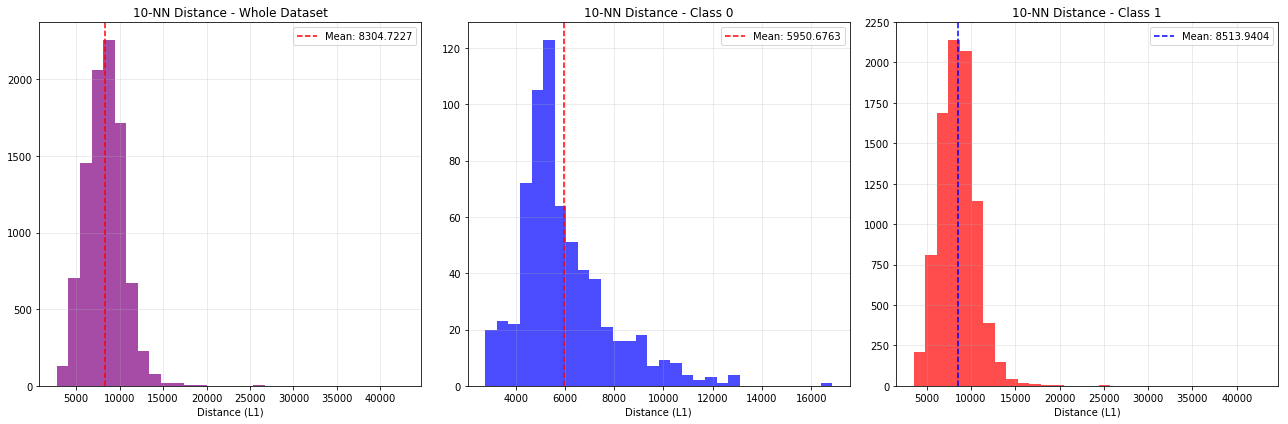

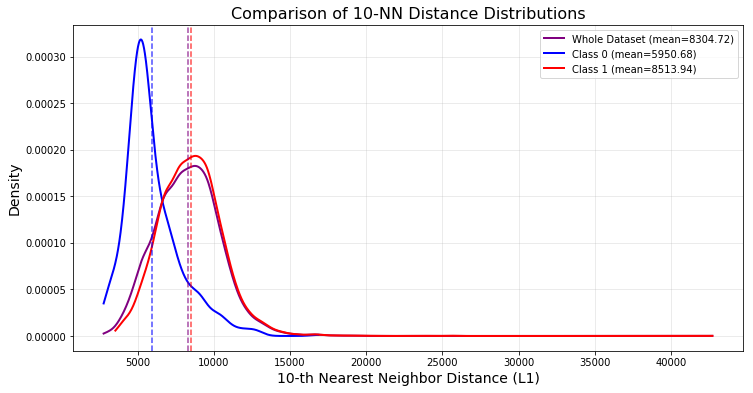


Statistical Comparison of 10-NN Distributions:
Whole vs Class 0: p=0.00000000 (Different)
Whole vs Class 1: p=0.00000000 (Different)
Class 0 vs Class 1: p=0.00000000 (Different)


In [22]:
import torch, pandas as pd, numpy as np, matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy import stats
import json


def compute_knn_analysis(data_path, k_values=[1, 3, 5, 10], batch_size=2000, chunk_size=5000):
    """Compute k-NN distances for the dataset and classes, plus nearest class distances"""
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load and prepare data
    df = pd.read_parquet(data_path)
    classes = df.iloc[:, 0].values
    feature_columns = df.columns[1:]
    class0_indices, class1_indices = np.where(classes == 0)[0], np.where(classes == 1)[0]
    
    print(f"Total: {len(df)}, Class 0: {len(class0_indices)}, Class 1: {len(class1_indices)}")
    
    df_class0, df_class1 = df.iloc[class0_indices].copy(), df.iloc[class1_indices].copy()
    class0_features = torch.tensor(df.iloc[class0_indices, 1:].values, dtype=torch.float32, device=device)
    class1_features = torch.tensor(df.iloc[class1_indices, 1:].values, dtype=torch.float32, device=device)
    features_tensor = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Calculate valid k values for each dataset
    max_k_whole, max_k_class0, max_k_class1 = len(features_tensor)-1, len(class0_features)-1, len(class1_features)-1
    valid_k_whole = [k for k in k_values if k <= max_k_whole]
    valid_k_class0 = [k for k in k_values if k <= max_k_class0]
    valid_k_class1 = [k for k in k_values if k <= max_k_class1]
    
    # Initialize results storage
    results = {
        'whole_dataset': {k: [] for k in valid_k_whole},
        'class0': {k: [] for k in valid_k_class0},
        'class1': {k: [] for k in valid_k_class1}
    }
    raw_distances = {
        'whole_dataset': {k: [] for k in valid_k_whole},
        'class0': {k: [] for k in valid_k_class0},
        'class1': {k: [] for k in valid_k_class1}
    }
    
    # 1. Compute k-NN distances for whole dataset
    if valid_k_whole:
        print("Computing k-NN distances for whole dataset...")
        for start_idx in tqdm(range(0, len(features_tensor), batch_size)):
            end_idx = min(start_idx + batch_size, len(features_tensor))
            batch = features_tensor[start_idx:end_idx]
            distances = torch.cdist(batch, features_tensor, p=1)
            
            for i, global_idx in enumerate(range(start_idx, end_idx)):
                distances[i, global_idx] = float('inf')  # Exclude self
                
                for k in valid_k_whole:
                    topk_values, _ = torch.topk(distances[i], k=k, largest=False)
                    kth_distance = topk_values[k-1].item()
                    results['whole_dataset'][k].append(kth_distance)
                    
                    if k == 10:  # Store 10-NN distances for distribution analysis
                        raw_distances['whole_dataset'][k].append(topk_values.cpu().numpy())
    
    # 2. Compute k-NN distances for class 0
    if valid_k_class0 and len(class0_features) > 1:
        print("Computing k-NN distances for class 0...")
        for start_idx in tqdm(range(0, len(class0_features), batch_size)):
            end_idx = min(start_idx + batch_size, len(class0_features))
            batch = class0_features[start_idx:end_idx]
            distances = torch.cdist(batch, class0_features, p=1)
            
            for i, global_idx in enumerate(range(start_idx, end_idx)):
                distances[i, global_idx] = float('inf')  # Exclude self
                
                for k in valid_k_class0:
                    topk_values, _ = torch.topk(distances[i], k=k, largest=False)
                    kth_distance = topk_values[k-1].item()
                    results['class0'][k].append(kth_distance)
                    
                    if k == 10:  # Store 10-NN distances
                        raw_distances['class0'][k].append(topk_values.cpu().numpy())
    
    # 3. Compute k-NN distances for class 1
    if valid_k_class1 and len(class1_features) > 1:
        print("Computing k-NN distances for class 1...")
        for start_idx in tqdm(range(0, len(class1_features), batch_size)):
            end_idx = min(start_idx + batch_size, len(class1_features))
            batch = class1_features[start_idx:end_idx]
            distances = torch.cdist(batch, class1_features, p=1)
            
            for i, global_idx in enumerate(range(start_idx, end_idx)):
                distances[i, global_idx] = float('inf')  # Exclude self
                
                for k in valid_k_class1:
                    topk_values, _ = torch.topk(distances[i], k=k, largest=False)
                    kth_distance = topk_values[k-1].item()
                    results['class1'][k].append(kth_distance)
                    
                    if k == 10:  # Store 10-NN distances
                        raw_distances['class1'][k].append(topk_values.cpu().numpy())
    
    # 4. Compute nearest class distances
    nearest_class1_indices = np.zeros(len(class0_features), dtype=int)
    nearest_class1_distances = np.zeros(len(class0_features), dtype=float)
    nearest_class0_indices = np.zeros(len(class1_features), dtype=int)
    nearest_class0_distances = np.zeros(len(class1_features), dtype=float)
    
    print("Finding nearest class 1 point for each class 0 point...")
    for start_idx in tqdm(range(0, len(class0_features), batch_size)):
        end_idx = min(start_idx + batch_size, len(class0_features))
        batch = class0_features[start_idx:end_idx]
        batch_min_distances = torch.full((end_idx - start_idx,), float('inf'), device=device)
        batch_min_indices = torch.zeros((end_idx - start_idx,), dtype=torch.long, device=device)
        
        for c1_start_idx in range(0, len(class1_features), chunk_size):
            c1_end_idx = min(c1_start_idx + chunk_size, len(class1_features))
            class1_chunk = class1_features[c1_start_idx:c1_end_idx]
            distances = torch.cdist(batch, class1_chunk, p=1)
            chunk_min_distances, chunk_min_indices = torch.min(distances, dim=1)
            
            update_mask = chunk_min_distances < batch_min_distances
            batch_min_distances[update_mask] = chunk_min_distances[update_mask]
            batch_min_indices[update_mask] = chunk_min_indices[update_mask] + c1_start_idx
        
        nearest_class1_indices[start_idx:end_idx] = batch_min_indices.cpu().numpy()
        nearest_class1_distances[start_idx:end_idx] = batch_min_distances.cpu().numpy()
    
    print("Finding nearest class 0 point for each class 1 point...")
    for start_idx in tqdm(range(0, len(class1_features), batch_size)):
        end_idx = min(start_idx + batch_size, len(class1_features))
        batch = class1_features[start_idx:end_idx]
        batch_min_distances = torch.full((end_idx - start_idx,), float('inf'), device=device)
        batch_min_indices = torch.zeros((end_idx - start_idx,), dtype=torch.long, device=device)
        
        for c0_start_idx in range(0, len(class0_features), chunk_size):
            c0_end_idx = min(c0_start_idx + chunk_size, len(class0_features))
            class0_chunk = class0_features[c0_start_idx:c0_end_idx]
            distances = torch.cdist(batch, class0_chunk, p=1)
            chunk_min_distances, chunk_min_indices = torch.min(distances, dim=1)
            
            update_mask = chunk_min_distances < batch_min_distances
            batch_min_distances[update_mask] = chunk_min_distances[update_mask]
            batch_min_indices[update_mask] = chunk_min_indices[update_mask] + c0_start_idx
        
        nearest_class0_indices[start_idx:end_idx] = batch_min_indices.cpu().numpy()
        nearest_class0_distances[start_idx:end_idx] = batch_min_distances.cpu().numpy()
    
    # 5. Find reciprocal nearest neighbors
    reciprocal_pairs = [(c0_idx, nearest_class1_indices[c0_idx]) for c0_idx in range(len(class0_features))
                        if c0_idx == nearest_class0_indices[nearest_class1_indices[c0_idx]]]
    print(f"Found {len(reciprocal_pairs)} reciprocal nearest neighbor pairs")
    
    # Calculate average results
    avg_results = {}
    for dataset, valid_ks in zip(['whole_dataset', 'class0', 'class1'], 
                                [valid_k_whole, valid_k_class0, valid_k_class1]):
        avg_results[dataset] = {k: np.mean(results[dataset][k]) if k in valid_ks and results[dataset][k] 
                               else float('nan') for k in k_values}
    
    avg_results['nearest_class1_distance'] = np.mean(nearest_class1_distances)
    avg_results['nearest_class0_distance'] = np.mean(nearest_class0_distances)
    
    print(f"Runtime: {time.time() - start_time:.2f} seconds")
    
    return {
        'avg_results': avg_results,
        'nearest_class1_distances': nearest_class1_distances,
        'nearest_class0_distances': nearest_class0_distances,
        'raw_10nn': raw_distances
    }

def plot_knn_distributions(distance_data, k_values):
    """Plot K-NN distributions and comparative visualizations"""
    avg_results = distance_data['avg_results']
    raw_10nn = distance_data['raw_10nn']
    
    # Print average k-NN distances table
    print("\nK-NN distances (k-th nearest neighbor):")
    print("-" * 60)
    print(f"{'k':<5} {'Whole Dataset':<15} {'Class 0':<15} {'Class 1':<15}")
    print("-" * 60)
    for k in k_values:
        whole_val = avg_results['whole_dataset'].get(k, float('nan'))
        class0_val = avg_results['class0'].get(k, float('nan'))
        class1_val = avg_results['class1'].get(k, float('nan'))
        
        whole_str = f"{whole_val:<15.4f}" if not np.isnan(whole_val) else "N/A           "
        class0_str = f"{class0_val:<15.4f}" if not np.isnan(class0_val) else "N/A           "
        class1_str = f"{class1_val:<15.4f}" if not np.isnan(class1_val) else "N/A           "
        
        print(f"{k:<5} {whole_str} {class0_str} {class1_str}")
    print("-" * 60)
    
    # Plot 10-NN distributions if available
    if 10 in raw_10nn['whole_dataset'] and 10 in raw_10nn['class0'] and 10 in raw_10nn['class1']:
        # Extract 10-NN distances
        tenth_nn_whole = [dist_array[9] for dist_array in raw_10nn['whole_dataset'][10]]
        tenth_nn_class0 = [dist_array[9] for dist_array in raw_10nn['class0'][10]]
        tenth_nn_class1 = [dist_array[9] for dist_array in raw_10nn['class1'][10]]
        
        # Plot individual distributions
        plt.figure(figsize=(18, 6))
        
        # First subplot: Whole dataset
        plt.subplot(1, 3, 1)
        plt.hist(tenth_nn_whole, bins=30, color='purple', alpha=0.7)
        plt.axvline(x=np.mean(tenth_nn_whole), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(tenth_nn_whole):.4f}')
        plt.title('10-NN Distance - Whole Dataset')
        plt.xlabel('Distance (L1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Second subplot: Class 0
        plt.subplot(1, 3, 2)
        plt.hist(tenth_nn_class0, bins=30, color='blue', alpha=0.7)
        plt.axvline(x=np.mean(tenth_nn_class0), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(tenth_nn_class0):.4f}')
        plt.title('10-NN Distance - Class 0')
        plt.xlabel('Distance (L1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Third subplot: Class 1
        plt.subplot(1, 3, 3)
        plt.hist(tenth_nn_class1, bins=30, color='red', alpha=0.7)
        plt.axvline(x=np.mean(tenth_nn_class1), color='blue', linestyle='--', 
                    label=f'Mean: {np.mean(tenth_nn_class1):.4f}')
        plt.title('10-NN Distance - Class 1')
        plt.xlabel('Distance (L1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Combined density plot (using matplotlib's kde instead of seaborn)
        plt.figure(figsize=(12, 6))
        
        # Plot KDE for each dataset
        from scipy.stats import gaussian_kde
        
        # Whole dataset KDE
        kde_whole = gaussian_kde(tenth_nn_whole)
        x_whole = np.linspace(min(tenth_nn_whole), max(tenth_nn_whole), 1000)
        plt.plot(x_whole, kde_whole(x_whole), 
                 label=f'Whole Dataset (mean={np.mean(tenth_nn_whole):.2f})', 
                 color='purple', linewidth=2)
        
        # Class 0 KDE
        kde_class0 = gaussian_kde(tenth_nn_class0)
        x_class0 = np.linspace(min(tenth_nn_class0), max(tenth_nn_class0), 1000)
        plt.plot(x_class0, kde_class0(x_class0), 
                 label=f'Class 0 (mean={np.mean(tenth_nn_class0):.2f})', 
                 color='blue', linewidth=2)
        
        # Class 1 KDE
        kde_class1 = gaussian_kde(tenth_nn_class1)
        x_class1 = np.linspace(min(tenth_nn_class1), max(tenth_nn_class1), 1000)
        plt.plot(x_class1, kde_class1(x_class1), 
                 label=f'Class 1 (mean={np.mean(tenth_nn_class1):.2f})', 
                 color='red', linewidth=2)
        
        # Add mean lines
        plt.axvline(x=np.mean(tenth_nn_whole), color='purple', linestyle='--', alpha=0.7)
        plt.axvline(x=np.mean(tenth_nn_class0), color='blue', linestyle='--', alpha=0.7)
        plt.axvline(x=np.mean(tenth_nn_class1), color='red', linestyle='--', alpha=0.7)
        
        plt.title('Comparison of 10-NN Distance Distributions', fontsize=16)
        plt.xlabel('10-th Nearest Neighbor Distance (L1)', fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Statistical comparison
        print("\nStatistical Comparison of 10-NN Distributions:")
        _, p_whole_c0 = stats.mannwhitneyu(tenth_nn_whole, tenth_nn_class0)
        _, p_whole_c1 = stats.mannwhitneyu(tenth_nn_whole, tenth_nn_class1)
        _, p_c0_c1 = stats.mannwhitneyu(tenth_nn_class0, tenth_nn_class1)
        
        print(f"Whole vs Class 0: p={p_whole_c0:.8f} ({'Different' if p_whole_c0<0.05 else 'Not different'})")
        print(f"Whole vs Class 1: p={p_whole_c1:.8f} ({'Different' if p_whole_c1<0.05 else 'Not different'})")
        print(f"Class 0 vs Class 1: p={p_c0_c1:.8f} ({'Different' if p_c0_c1<0.05 else 'Not different'})")

# Execute analysis
if __name__ == "__main__":
    k_values = [1, 3, 5, 10, 15, 20]
    distance_data = compute_knn_analysis(
        data_path='data_norm.parquet',
        k_values=k_values,
        batch_size=1000,
        chunk_size=5000
    )
    plot_knn_distributions(distance_data, k_values)

In [4]:
import torch
import numpy as np
import pandas as pd
import time
import os
from tqdm import tqdm
import math

class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 2000)
        self.bn1 = torch.nn.BatchNorm1d(2000)
        self.dropout1 = torch.nn.Dropout(0.02)
        self.fc2 = torch.nn.Linear(2000, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.dropout2 = torch.nn.Dropout(0.02)
        self.fc3 = torch.nn.Linear(200, 20)
        self.bn3 = torch.nn.BatchNorm1d(20)
        self.dropout3 = torch.nn.Dropout(0.02)
        self.fc4 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        
    def forward(self, x):
        # Handle batch norm for single samples if needed
        if x.dim() == 2 and x.size(0) == 1:
            # For a single sample, clone it to make a batch of 2
            x_batch = torch.cat([x, x], dim=0)
            x_batch = self.leaky_relu(self.bn1(self.fc1(x_batch)))
            x_batch = self.dropout1(x_batch)
            x_batch = self.leaky_relu(self.bn2(self.fc2(x_batch)))
            x_batch = self.dropout2(x_batch)
            x_batch = self.leaky_relu(self.bn3(self.fc3(x_batch)))
            x_batch = self.dropout3(x_batch)
            x_batch = self.sigmoid(self.fc4(x_batch))
            return x_batch[0:1]  # Return only the first sample
        else:
            # Normal batch processing
            x = self.leaky_relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            x = self.leaky_relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = self.leaky_relu(self.bn3(self.fc3(x)))
            x = self.dropout3(x)
            x = self.sigmoid(self.fc4(x))
            return x
        
    def find_boundary_intersection(self, x_factual, x_counterfactual, eps=1e-5, max_iterations=50):
        """
        Find the point on the decision boundary that intersects the line between factual and counterfactual
        
        Args:
            x_factual: Factual sample tensor
            x_counterfactual: Counterfactual sample tensor
            eps: Precision threshold
            max_iterations: Maximum number of binary search iterations
            
        Returns:
            Intersection point and distance from factual to intersection
        """
        with torch.no_grad():
            # Get predictions for both points
            fact_pred = self.forward(x_factual).item()
            cf_pred = self.forward(x_counterfactual).item()
            
            # Check if predictions are different enough (i.e., on opposite sides of the boundary)
            # Use a slightly relaxed condition to handle border cases
            if (fact_pred > 0.55 and cf_pred > 0.55) or (fact_pred < 0.45 and cf_pred < 0.45):
                # If both are clearly on the same side, use the distance to counterfactual
                # This is a reasonable fallback rather than returning infinity
                return x_counterfactual, torch.sum(torch.abs(x_counterfactual - x_factual)).item()
            
            # Direction vector from factual to counterfactual
            direction = x_counterfactual - x_factual
            
            # Get direction magnitude (for normalizing)
            direction_mag = torch.norm(direction, p=1).item()
            if direction_mag < eps:  # If points are too close
                return x_factual, 0.0
                
            # Initialize binary search
            low = 0.0  # factual point
            high = 1.0  # counterfactual point
            
            # Binary search for the decision boundary
            for _ in range(max_iterations):
                mid = (low + high) / 2.0
                x_mid = x_factual + mid * direction
                pred_mid = self.forward(x_mid).item()
                
                # Check if we're close enough to the boundary
                if abs(pred_mid - 0.5) < eps:
                    # Calculate L1 distance from factual to intersection
                    distance = torch.sum(torch.abs(x_mid - x_factual)).item()
                    return x_mid, distance
                
                # Update search range
                if (pred_mid > 0.5 and fact_pred > 0.5) or (pred_mid < 0.5 and fact_pred < 0.5):
                    # Mid point is on same side as factual
                    low = mid
                else:
                    # Mid point is on same side as counterfactual
                    high = mid
                    
                # Check if our search range is small enough
                if high - low < eps:
                    x_intersection = x_factual + mid * direction
                    distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
                    return x_intersection, distance
            
            # If we reach max iterations, return the midpoint
            x_intersection = x_factual + ((low + high) / 2.0) * direction
            distance = torch.sum(torch.abs(x_intersection - x_factual)).item()
            return x_intersection, distance

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_median_absolute_deviation(data_tensor):
    """Compute median absolute deviation for each feature"""
    median = torch.median(data_tensor, dim=0).values
    deviation = torch.abs(data_tensor - median)
    mad = torch.median(deviation, dim=0).values
    # Replace zero MAD values with 1 to avoid division by zero
    mad[mad == 0] = 1.0
    return mad

def update_evaluation_file(name, metric, value, results, output_file="evaluation.txt"):
    """Update the evaluation file with the current results"""
    # Store the result - don't write to file yet (will be done at the end)
    results[name][metric] = value
    
    # Print the update
    print(f"Updated results with {name} - {metric}: {value:.4f}")
    
    return results

def compute_gaussian_probability(distance, mean, variance):
    """
    Compute the probability P(abs(x-mean) > abs(distance-mean))
    This gives the probability of being further from the mean than this distance
    """
    # Calculate how far we are from the mean
    distance_from_mean = abs(distance - mean)
    
    # Compute the probability of being further from the mean (one-sided)
    # This is equivalent to 2 * (1 - CDF(|x-mean|))
    z_score = distance_from_mean / math.sqrt(variance)
    probability = 2 * (1 - 0.5 * (1 + math.erf(z_score / math.sqrt(2))))
    
    return probability


import json

@torch.no_grad()
def evaluate_counterfactuals(
    original_data_path,
    counterfactual_dfs,
    model_path,
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True,
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=0,
    output_path="evaluation_results.json"
):
    """
    Evaluate counterfactuals using multiple metrics
    
    Args:
        original_data_path: Path to original data
        counterfactual_dfs: Dictionary mapping names to counterfactual DataFrames or paths
        model_path: Path to trained model
        metrics_to_compute: Dictionary specifying which metrics to compute
        batch_size: Batch size for GPU processing
        gpu_id: GPU device ID to use
        output_path: Path to output evaluation results as JSON
        
    Returns:
        Dictionary of evaluation results per counterfactual set
    """
    start_time = time.time()
    
    # Set device
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load original data
    print("Loading original data...")
    original_df = pd.read_parquet(original_data_path)
    
    # Process counterfactual dataframes
    cf_data = {}
    for name, cf_df_or_path in counterfactual_dfs.items():
        if isinstance(cf_df_or_path, str):
            cf_data[name] = pd.read_parquet(cf_df_or_path)
        else:
            cf_data[name] = cf_df_or_path
    
    # Extract feature names (excluding class column and original_index)
    feature_names = list(original_df.columns)[1:]  # Exclude first column (class)
    num_features = len(feature_names)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Prepare data for GPU
    # Convert original data to tensor (exclude class column)
    original_features = torch.tensor(original_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    # Compute median absolute deviation (MAD) for normalization
    mad = compute_median_absolute_deviation(original_features)
    
    # Extract class information
    original_classes = original_df.iloc[:, 0].values
    
    # Create dictionary to store results
    results = {name: {} for name in cf_data.keys()}
    
    # Gaussian parameters for new metrics
    dataset_gaussian_mean = 8304.722022
    dataset_gaussian_variance = 4707926.898804
    class0_gaussian_mean = 5950.676427
    class0_gaussian_variance = 3400381.504375
    
    # Pre-compute class 0 mask for the original data
    class0_mask = torch.tensor(original_classes == 0, device=device)
    class0_samples = original_features[class0_mask] if torch.any(class0_mask) else None
    
    # Process each counterfactual dataset
    for name, cf_df in cf_data.items():
        print(f"\nEvaluating: {name}")
        
        # FIXED: Direct mapping from counterfactual to original row positions
        cf_to_orig_map = {}
        if 'original_index' in cf_df.columns:
            for i, row in enumerate(cf_df.itertuples()):
                # original_index directly gives the row position in data_norm
                orig_position = int(row.original_index)
                if 0 <= orig_position < len(original_df):
                    cf_to_orig_map[i] = orig_position
                else:
                    cf_to_orig_map[i] = -1
        else:
            # Assume sample_id column refers to row positions as well
            for i, row in enumerate(cf_df.itertuples()):
                if hasattr(row, 'sample_id'):
                    orig_position = int(row.sample_id)
                    if 0 <= orig_position < len(original_df):
                        cf_to_orig_map[i] = orig_position
                    else:
                        cf_to_orig_map[i] = -1
                else:
                    cf_to_orig_map[i] = -1
        
        # Convert counterfactual features to tensor (exclude class column and original_index/sample_id)
        if 'original_index' in cf_df.columns:
            cf_features = torch.tensor(cf_df.iloc[:, 1:-1].values, dtype=torch.float32, device=device)
        else:
            # Assume first column is class and rest are features (no original_index)
            cf_features = torch.tensor(cf_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
        
        # Organize counterfactuals by original index
        cf_by_orig = {}
        for cf_idx, orig_idx in cf_to_orig_map.items():
            if orig_idx != -1:
                if orig_idx not in cf_by_orig:
                    cf_by_orig[orig_idx] = []
                cf_by_orig[orig_idx].append(cf_idx)
        
        # Store metric values for this counterfactual set
        metric_values = {}
        
        # ------ Compute metrics ------
        
        # 1. Validity
        if metrics_to_compute.get('validity', False):
            print("Computing validity...")
            validity_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get predictions for valid counterfactuals
                valid_cf = batch_cf[list(batch_cf_indices)]
                cf_preds = model(valid_cf).cpu().numpy()
                
                # Get predictions for corresponding original samples
                orig_samples = original_features[list(batch_orig_indices)]
                orig_preds = model(orig_samples).cpu().numpy()
                
                # Compute validity for each counterfactual
                for cf_pred, orig_pred in zip(cf_preds, orig_preds):
                    # Binary label change (0 or 1)
                    validity_score = abs(float(cf_pred > 0.5) - float(orig_pred >= 0.5))
                    validity_scores.append(validity_score)
            
            if validity_scores:
                min_val = float(np.min(validity_scores))
                avg_val = float(np.mean(validity_scores))
                max_val = float(np.max(validity_scores))
                std_val = float(np.std(validity_scores))
                metric_values['validity'] = [min_val, avg_val, max_val, std_val]
                print(f"validity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 2-3. Proximity and Sparsity
        if metrics_to_compute.get('proximity', False) or metrics_to_compute.get('sparsity', False) or metrics_to_compute.get('sparsity_count', False):
            print("Computing proximity and sparsity...")
            proximity_scores = []
            sparsity_scores = []
            sparsity_count_scores = []
            
            # Process in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get original indices for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                
                # Filter out invalid mappings
                valid_indices = [(i, orig_idx) for i, orig_idx in enumerate(batch_orig_indices) if orig_idx != -1]
                if not valid_indices:
                    continue
                
                # Split into cf indices and orig indices
                batch_cf_indices, batch_orig_indices = zip(*valid_indices)
                
                # Get valid counterfactuals and corresponding original samples
                valid_cf = batch_cf[list(batch_cf_indices)]
                orig_samples = original_features[list(batch_orig_indices)]
                
                # Compute absolute differences
                abs_diff = torch.abs(valid_cf - orig_samples)
                
                # Compute proximity (L1 distance normalized by MAD)
                if metrics_to_compute.get('proximity', False):
                    normalized_diff = abs_diff / mad
                    batch_proximity = torch.mean(normalized_diff, dim=1)
                    proximity_scores.extend(batch_proximity.cpu().numpy())
                
                # Compute sparsity (1 - proportion of changed features)
                if metrics_to_compute.get('sparsity', False):
                    # Consider a feature changed if abs_diff > 1e-2
                    changed_features = (abs_diff > 1e-2).float()
                    batch_sparsity = 1 - torch.mean(changed_features, dim=1)
                    sparsity_scores.extend(batch_sparsity.cpu().numpy())
                    
                # Compute sparsity count (raw count of changed features)
                if metrics_to_compute.get('sparsity_count', False):
                    changed_count = torch.sum((abs_diff > 1e-2).float(), dim=1)
                    sparsity_count_scores.extend(changed_count.cpu().numpy())
            
            if metrics_to_compute.get('proximity', False) and proximity_scores:
                min_val = float(np.min(proximity_scores))
                avg_val = float(np.mean(proximity_scores))
                max_val = float(np.max(proximity_scores))
                std_val = float(np.std(proximity_scores))
                metric_values['proximity'] = [min_val, avg_val, max_val, std_val]
                print(f"proximity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                
            if metrics_to_compute.get('sparsity', False) and sparsity_scores:
                min_val = float(np.min(sparsity_scores))
                avg_val = float(np.mean(sparsity_scores))
                max_val = float(np.max(sparsity_scores))
                std_val = float(np.std(sparsity_scores))
                metric_values['sparsity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
                    
            if metrics_to_compute.get('sparsity_count', False) and sparsity_count_scores:
                min_val = float(np.min(sparsity_count_scores))
                avg_val = float(np.mean(sparsity_count_scores))
                max_val = float(np.max(sparsity_count_scores))
                std_val = float(np.std(sparsity_count_scores))
                metric_values['sparsity_count'] = [min_val, avg_val, max_val, std_val]
                print(f"sparsity_count: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 4. Diversity
        if metrics_to_compute.get('diversity', False):
            print("Computing diversity...")
            diversity_scores = []
            
            # For each original sample, compute diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    
                    # Compute pairwise distances using torch.cdist (fully vectorized)
                    # Using raw L1 distances without MAD normalization
                    pairwise_distances = torch.cdist(orig_cfs, orig_cfs, p=1)
                    
                    # Extract the upper triangular part (excluding diagonal)
                    mask = torch.triu(torch.ones_like(pairwise_distances), diagonal=1).bool()
                    distances = pairwise_distances[mask]
                    
                    # Compute average distance
                    if len(distances) > 0:
                        avg_distance = torch.mean(distances).item()
                        diversity_scores.append(avg_distance)
            
            if diversity_scores:
                min_val = float(np.min(diversity_scores))
                avg_val = float(np.mean(diversity_scores))
                max_val = float(np.max(diversity_scores))
                std_val = float(np.std(diversity_scores))
                metric_values['diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 5. Sparse Diversity
        if metrics_to_compute.get('sparse_diversity', False):
            print("Computing sparse diversity...")
            sparse_diversity_scores = []
            
            # For each original sample, compute sparse diversity of its counterfactuals
            for orig_idx, cf_indices in cf_by_orig.items():
                if len(cf_indices) > 1:  # Need at least 2 CFs to compute diversity
                    # Get counterfactuals for this original sample
                    orig_cfs = cf_features[cf_indices]
                    orig_sample = original_features[orig_idx]
                    
                    # Identify changed features for each counterfactual (binary mask)
                    changed_features = (torch.abs(orig_cfs - orig_sample.unsqueeze(0)) > 1e-5).float()
                    
                    # Number of counterfactuals
                    n_cfs = len(cf_indices)
                    
                    # Vectorized intersection computation
                    # Changed features is [n_cfs, num_features]
                    # We'll compute intersection for all pairs at once
                    
                    # Create expanded tensors for broadcasting
                    # [n_cfs, 1, num_features] and [1, n_cfs, num_features]
                    features_i = changed_features.unsqueeze(1)
                    features_j = changed_features.unsqueeze(0)
                    
                    # Compute intersection and union for all pairs
                    intersection = torch.sum(features_i * features_j, dim=2)  # [n_cfs, n_cfs]
                    union = torch.sum(torch.clamp(features_i + features_j, 0, 1), dim=2)  # [n_cfs, n_cfs]
                    
                    # Create a mask for valid pairs (upper triangle, excluding diagonal)
                    mask = torch.triu(torch.ones(n_cfs, n_cfs, device=device), diagonal=1).bool()
                    
                    # Get valid intersection and union values
                    valid_intersection = intersection[mask]
                    valid_union = union[mask]
                    
                    # Compute IoU (avoid division by zero)
                    valid_mask = valid_union > 0
                    if torch.any(valid_mask):
                        iou = torch.zeros_like(valid_intersection)
                        iou[valid_mask] = valid_intersection[valid_mask] / valid_union[valid_mask]
                        
                        # Compute average IoU
                        avg_overlap = torch.mean(iou).item()
                        sparse_diversity_scores.append(1 - avg_overlap)
            
            if sparse_diversity_scores:
                min_val = float(np.min(sparse_diversity_scores))
                avg_val = float(np.mean(sparse_diversity_scores))
                max_val = float(np.max(sparse_diversity_scores))
                std_val = float(np.std(sparse_diversity_scores))
                metric_values['sparse_diversity'] = [min_val, avg_val, max_val, std_val]
                print(f"sparse_diversity: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # 6-8. New Metrics: Average 10-NN Distance and Probabilities
        # Initialize storage for distances
        avg_10nn_distances_list = []
        avg_10nn_dataset_probs = []
        avg_10nn_class0_probs = []
        
        # First compute k-NN distances for each counterfactual
        if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False) or metrics_to_compute.get('avg_10nn_class0', False):
            print("Computing 10-NN distances in dataset and class 0...")
            
            # Process counterfactuals in batches
            for start_idx in range(0, len(cf_features), batch_size):
                end_idx = min(start_idx + batch_size, len(cf_features))
                batch_cf = cf_features[start_idx:end_idx]
                
                # Get mappings for this batch
                batch_orig_indices = [cf_to_orig_map.get(i, -1) for i in range(start_idx, end_idx)]
                valid_mask = torch.tensor([idx != -1 for idx in batch_orig_indices], device=device)
                
                if not torch.any(valid_mask):
                    continue
                
                valid_cf = batch_cf[valid_mask]
                valid_orig_indices = [idx for idx in batch_orig_indices if idx != -1]
                
                # Find the 10 nearest neighbors in the entire dataset
                if metrics_to_compute.get('avg_10nn_distance', False) or metrics_to_compute.get('avg_10nn_dataset', False):
                    # Initialize storage for 10-NN distances
                    k = 11  # k+1 to avoid counting self (though unlikely to be exact match)
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process original data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(original_features), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(original_features))
                        data_chunk = original_features[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take the next 10
                    avg_10nn_distances = torch.mean(knn_distances[:, 1:11], dim=1)
                    
                    # Save raw distances for the avg_10nn_distance metric
                    if metrics_to_compute.get('avg_10nn_distance', False):
                        avg_10nn_distances_list.extend(avg_10nn_distances.cpu().numpy())
                    
                    # Compute the Gaussian probability for each distance
                    if metrics_to_compute.get('avg_10nn_dataset', False):
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, dataset_gaussian_mean, dataset_gaussian_variance)
                            avg_10nn_dataset_probs.append(prob)
                
                # Find the 10 nearest neighbors in class 0
                if metrics_to_compute.get('avg_10nn_class0', False) and class0_samples is not None and len(class0_samples) > 0:
                    # Initialize storage for 10-NN distances
                    k = min(11, len(class0_samples))  # k+1 to avoid self, but cap at available samples
                    knn_distances = torch.full((len(valid_cf), k), float('inf'), device=device)
                    
                    # Process class 0 data in chunks
                    chunk_size = 5000  # Adjust based on available GPU memory
                    for chunk_start in range(0, len(class0_samples), chunk_size):
                        chunk_end = min(chunk_start + chunk_size, len(class0_samples))
                        data_chunk = class0_samples[chunk_start:chunk_end]
                        
                        # Compute pairwise L1 distances between valid_cf and this chunk
                        distances = torch.cdist(valid_cf, data_chunk, p=1)
                        
                        # Update top-k distances
                        combined = torch.cat([knn_distances, distances], dim=1)
                        topk_values, _ = torch.topk(combined, k=k, dim=1, largest=False)
                        knn_distances = topk_values
                    
                    # Calculate average 10-NN distance for each counterfactual
                    # Skip the first one (potentially self) and take up to the next 10
                    if k > 1:
                        # Use as many neighbors as available after skipping the first one
                        neighbors_to_use = min(10, k-1)
                        avg_10nn_distances = torch.mean(knn_distances[:, 1:1+neighbors_to_use], dim=1)
                        
                        # Compute the Gaussian probability for each distance
                        for dist in avg_10nn_distances.cpu().numpy():
                            prob = compute_gaussian_probability(dist, class0_gaussian_mean, class0_gaussian_variance)
                            avg_10nn_class0_probs.append(prob)
            
            # Compute and save metrics with min, avg, max, std
            if metrics_to_compute.get('avg_10nn_distance', False) and avg_10nn_distances_list:
                min_val = float(np.min(avg_10nn_distances_list))
                avg_val = float(np.mean(avg_10nn_distances_list))
                max_val = float(np.max(avg_10nn_distances_list))
                std_val = float(np.std(avg_10nn_distances_list))
                metric_values['avg_10nn_distance'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_distance: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_dataset', False) and avg_10nn_dataset_probs:
                min_val = float(np.min(avg_10nn_dataset_probs))
                avg_val = float(np.mean(avg_10nn_dataset_probs))
                max_val = float(np.max(avg_10nn_dataset_probs))
                std_val = float(np.std(avg_10nn_dataset_probs))
                metric_values['avg_10nn_dataset_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_dataset_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
            
            if metrics_to_compute.get('avg_10nn_class0', False) and avg_10nn_class0_probs:
                min_val = float(np.min(avg_10nn_class0_probs))
                avg_val = float(np.mean(avg_10nn_class0_probs))
                max_val = float(np.max(avg_10nn_class0_probs))
                std_val = float(np.std(avg_10nn_class0_probs))
                metric_values['avg_10nn_class0_probability'] = [min_val, avg_val, max_val, std_val]
                print(f"avg_10nn_class0_probability: min={min_val:.4f}, avg={avg_val:.4f}, max={max_val:.4f}, std={std_val:.4f}")
        
        # Store metric values for this counterfactual set
        results[name] = metric_values
    
        # Print summary
        print("\nEvaluation Summary:")
        for name, metrics in results.items():
            print(f"\n{name}:")
            for metric, values in metrics.items():
                print(f"  {metric}: min={values[0]:.4f}, avg={values[1]:.4f}, max={values[2]:.4f}, std={values[3]:.4f}")

        elapsed_time = time.time() - start_time
        print(f"\nTotal evaluation time: {elapsed_time:.2f} seconds")

    # Write results to JSON file - modified to append to existing file if present
    print(f"\nSaving results to {output_path}")
    try:
        # Try to load existing JSON file
        if os.path.exists(output_path):
            with open(output_path, 'r') as f:
                try:
                    existing_results = json.load(f)
                    print(f"Successfully loaded existing results from {output_path}")

                    # Update with new results (append or overwrite)
                    for name, metrics in results.items():
                        if name in existing_results:
                            print(f"Updating existing entry: {name}")
                        else:
                            print(f"Adding new entry: {name}")
                        existing_results[name] = metrics

                    # Save updated results
                    results = existing_results
                except json.JSONDecodeError:
                    print(f"Could not parse existing file as JSON. Creating new file.")

        # Write the combined results
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)

        print(f"Results successfully written to {output_path}")
    except Exception as e:
        print(f"Error saving results to {output_path}: {str(e)}")
        # Create a backup file in case of error
        backup_path = f"{output_path}.backup"
        with open(backup_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Backup saved to {backup_path}")

        return results



    
    




results = evaluate_counterfactuals(
    original_data_path='data_norm.parquet',
    counterfactual_dfs = {
        '3cf_p001': '3cf_p001.parquet',
        '3cf_p0001': '3cf_p0001.parquet',
        '3cf_p00001': '3cf_p00001.parquet',
        '3cf_d001': '3cf_d001.parquet',
        '3cf_d0001': '3cf_d0001.parquet',
        '3cf_d00001': '3cf_d00001.parquet'
    },
    model_path='mlp_model.pth',
    metrics_to_compute={
        'validity': True,
        'proximity': True,
        'sparsity': True,
        'sparsity_count': True,
        'diversity': True,
        'sparse_diversity': True,
        'avg_10nn_distance': True, 
        'avg_10nn_dataset': True,
        'avg_10nn_class0': True
    },
    batch_size=512,
    gpu_id=0,
    output_path="evaluation_with_knn_metrics.json"
)

Using device: cuda:0
Loading original data...

Evaluating: 3cf_p001
Computing validity...
validity: min=0.0000, avg=0.9977, max=1.0000, std=0.0479
Computing proximity and sparsity...
proximity: min=28.2310, avg=44.4079, max=255.4384, std=23.8147
sparsity: min=0.0029, avg=0.0136, max=0.0261, std=0.0032
sparsity_count: min=19367.0000, avg=19615.9492, max=19830.0000, std=62.9235
Computing diversity...
diversity: min=489.2701, avg=841.2717, max=1468.6396, std=127.0715
Computing sparse diversity...
sparse_diversity: min=0.0001, avg=0.0011, max=0.0026, std=0.0004
Computing 10-NN distances in dataset and class 0...
avg_10nn_distance: min=7043.9253, avg=8622.5420, max=10229.7334, std=537.2386
avg_10nn_dataset_probability: min=0.3750, avg=0.8203, max=0.9999, std=0.1288
avg_10nn_class0_probability: min=0.0040, avg=0.0750, max=0.4288, std=0.0485

Evaluation Summary:

3cf_p001:
  validity: min=0.0000, avg=0.9977, max=1.0000, std=0.0479
  proximity: min=28.2310, avg=44.4079, max=255.4384, std=23.81

In [8]:
from numba import cuda
cuda.select_device(0)
cuda.close()
print('dkf')

dkf


In [ ]:
   counterfactual_dfs = {
        # Base counterfactuals
        '3cf': '3cf.parquet',
        '6cf': '6cf.parquet',
        '10cf': '10cf.parquet',
        '16cf': '16cf.parquet',
        
        # 3cf variants with proximity parameter
        '3cf_p01': '3cf_p01.parquet',
        '3cf_p05': '3cf_p05.parquet',
        '3cf_p08': '3cf_p08.parquet',
        '3cf_p12': '3cf_p12.parquet',
        '3cf_p18': '3cf_p18.parquet',
        '3cf_p30': '3cf_p30.parquet',
        
        # 3cf variants with diversity parameter
        '3cf_d01': '3cf_d01.parquet',
        '3cf_d05': '3cf_d05.parquet',
        '3cf_d08': '3cf_d08.parquet',
        '3cf_d12': '3cf_d12.parquet',
        '3cf_d18': '3cf_d18.parquet',
        '3cf_d30': '3cf_d30.parquet',
        
        # 6cf variants with proximity parameter
        '6cf_p01': '6cf_p01.parquet',
        '6cf_p05': '6cf_p05.parquet',
        '6cf_p08': '6cf_p08.parquet',
        '6cf_p12': '6cf_p12.parquet',
        '6cf_p18': '6cf_p18.parquet',
        '6cf_p30': '6cf_p30.parquet',
        
        # 6cf variants with diversity parameter
        '6cf_d01': '6cf_d01.parquet',
        '6cf_d05': '6cf_d05.parquet',
        '6cf_d08': '6cf_d08.parquet',
        '6cf_d12': '6cf_d12.parquet',
        '6cf_d18': '6cf_d18.parquet',
        '6cf_d8': '6cf_d8.parquet',
        
        # 10cf variants with proximity parameter
        '10cf_p01': '10cf_p01.parquet',
        '10cf_p05': '10cf_p05.parquet',
        '10cf_p08': '10cf_p08.parquet',
        '10cf_p12': '10cf_p12.parquet',
        '10cf_p18': '10cf_p18.parquet',
        '10cf_p30': '10cf_p30.parquet',
        
        # 10cf variants with diversity parameter
        '10cf_d01': '10cf_d01.parquet',
        '10cf_d05': '10cf_d05.parquet',
        '10cf_d08': '10cf_d08.parquet',
        '10cf_d12': '10cf_d12.parquet',
        '10cf_d18': '10cf_d18.parquet',
        '10cf_d8': '10cf_d8.parquet',
        
        # 16cf variants with proximity parameter
        '16cf_p01': '16cf_p01.parquet',
        '16cf_p05': '16cf_p05.parquet',
        '16cf_p08': '16cf_p08.parquet',
        '16cf_p12': '16cf_p12.parquet',
        '16cf_p18': '16cf_p18.parquet',
        '16cf_p30': '16cf_p30.parquet',
        
        # 16cf variants with diversity parameter
        '16cf_d01': '16cf_d01.parquet',
        '16cf_d05': '16cf_d05.parquet',
        '16cf_d08': '16cf_d08.parquet',
        '16cf_d12': '16cf_d12.parquet',
        '16cf_d18': '16cf_d18.parquet',
        '16cf_d8': '16cf_d8.parquet'
    },
    
    counterfactual_dfs = {
        's_10cf_grad_asc': 's_10cf_grad_asc.parquet',
        's_10cf_grad_desc': 's_10cf_grad_desc.parquet',
        's_10cf_percentile_002_asc': 's_10cf_percentile_002_asc.parquet',
        's_10cf_percentile_002_desc': 's_10cf_percentile_002_desc.parquet',
        's_10cf_percentile_010_asc': 's_10cf_percentile_010_asc.parquet',
        's_10cf_percentile_010_desc': 's_10cf_percentile_010_desc.parquet',
        's_10cf_percentile_020_asc': 's_10cf_percentile_020_asc.parquet',
        's_10cf_percentile_020_desc': 's_10cf_percentile_020_desc.parquet',
        's_10cf_percentile_030_asc': 's_10cf_percentile_030_asc.parquet',
        's_10cf_percentile_030_desc': 's_10cf_percentile_030_desc.parquet',
        's_16cf_grad_asc': 's_16cf_grad_asc.parquet',
        's_16cf_grad_desc': 's_16cf_grad_desc.parquet',
        's_16cf_percentile_002_asc': 's_16cf_percentile_002_asc.parquet',
        's_16cf_percentile_002_desc': 's_16cf_percentile_002_desc.parquet',
        's_16cf_percentile_010_asc': 's_16cf_percentile_010_asc.parquet',
        's_16cf_percentile_010_desc': 's_16cf_percentile_010_desc.parquet',
        's_16cf_percentile_020_asc': 's_16cf_percentile_020_asc.parquet',
        's_16cf_percentile_020_desc': 's_16cf_percentile_020_desc.parquet',
        's_16cf_percentile_030_asc': 's_16cf_percentile_030_asc.parquet',
        's_16cf_percentile_030_desc': 's_16cf_percentile_030_desc.parquet',
        's_3cf_grad_asc': 's_3cf_grad_asc.parquet',
        's_3cf_grad_desc': 's_3cf_grad_desc.parquet',
        's_3cf_percentile_002_asc': 's_3cf_percentile_002_asc.parquet',
        's_3cf_percentile_002_desc': 's_3cf_percentile_002_desc.parquet',
        's_3cf_percentile_010_asc': 's_3cf_percentile_010_asc.parquet',
        's_3cf_percentile_010_desc': 's_3cf_percentile_010_desc.parquet',
        's_3cf_percentile_020_asc': 's_3cf_percentile_020_asc.parquet',
        's_3cf_percentile_020_desc': 's_3cf_percentile_020_desc.parquet',
        's_3cf_percentile_030_asc': 's_3cf_percentile_030_asc.parquet',
        's_3cf_percentile_030_desc': 's_3cf_percentile_030_desc.parquet',
        's_6cf_grad_asc': 's_6cf_grad_asc.parquet',
        's_6cf_grad_desc': 's_6cf_grad_desc.parquet',
        's_6cf_percentile_002_asc': 's_6cf_percentile_002_asc.parquet',
        's_6cf_percentile_002_desc': 's_6cf_percentile_002_desc.parquet',
        's_6cf_percentile_010_asc': 's_6cf_percentile_010_asc.parquet',
        's_6cf_percentile_010_desc': 's_6cf_percentile_010_desc.parquet',
        's_6cf_percentile_020_asc': 's_6cf_percentile_020_asc.parquet',
        's_6cf_percentile_020_desc': 's_6cf_percentile_020_desc.parquet',
        's_6cf_percentile_030_asc': 's_6cf_percentile_030_asc.parquet',
        's_6cf_percentile_030_desc': 's_6cf_percentile_030_desc.parquet'
    },
    
# For n=6 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.5,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p08.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.2,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=3,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_p30.parquet'
)



generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.1,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.5,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.8,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d08.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.2,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.8,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=3,
    gpu_id=0,
    num_cfs=6,
    batch_size=512,
    output_path='6cf_d8.parquet'
)

# For n=10 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.5,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p08.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.2,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=3,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_p30.parquet'
)



generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.1,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.5,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.8,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d08.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.2,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.8,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=3,
    gpu_id=0,
    num_cfs=10,
    batch_size=256,
    output_path='10cf_d8.parquet'
)

# For n=16 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.5,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p08.parquet'
)


generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.2,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1.8,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=3,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_p30.parquet'
)



generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.1,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d01.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.5,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d05.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.8,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d08.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.2,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d12.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1.8,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d18.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=3,
    gpu_id=0,
    num_cfs=16,
    batch_size=64,
    output_path='16cf_d8.parquet'
)

# For n=3 counterfactuals
generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.1,
    diversity_weight=10,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p10.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.5,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p100.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1000,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p1000.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.01,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.001,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p0001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0,
    diversity_weight=1,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_p0.parquet'
)



generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=10,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d10.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=100,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d100.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0.001,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d0001.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=1,
    diversity_weight=0,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_d0.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0,
    diversity_weight=0,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_0.parquet'
)

generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.1,
    diversity_weight=0.1,
    gpu_id=0,
    num_cfs=3,
    batch_size=32,
    output_path='3cf_01.parquet'
)



generate_counterfactuals(
    data_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    proximity_weight=0.5,
    diversity_weight=0.5,
    gpu_id=0,
    num_cfs=3,
    batch_size=1024,
    output_path='3cf_05.parquet'
)

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import time
from datetime import datetime
import gc
import os

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

class HighPerformanceProgressTracker:
    """Optimized progress tracker for maximum performance"""
    def __init__(self, total_samples, total_features, n_points_per_feature):
        self.total_samples = total_samples
        self.total_features = total_features
        self.n_points_per_feature = n_points_per_feature
        self.total_operations = total_samples * total_features
        self.completed_operations = 0
        self.start_time = time.time()
        self.last_update_time = self.start_time
        self.update_interval = 5.0  # Update every 5 seconds
        
        print(f"High-Performance Counterfactual Computation:")
        print(f"- Samples: {total_samples:,} | Features: {total_features:,} | Points/feature: {n_points_per_feature}")
        print(f"- Total operations: {self.total_operations:,}")
        print("-" * 90)
    
    def update(self, samples_completed, features_completed):
        """Fast progress updates"""
        operations_completed = samples_completed * self.total_features + features_completed
        self.completed_operations = operations_completed
        current_time = time.time()
        
        if current_time - self.last_update_time >= self.update_interval:
            progress_pct = (self.completed_operations / self.total_operations) * 100
            elapsed_time = current_time - self.start_time
            
            if self.completed_operations > 0:
                remaining_time = elapsed_time * (self.total_operations / self.completed_operations) - elapsed_time
                ops_per_second = self.completed_operations / elapsed_time
                
                if remaining_time >= 3600:
                    time_str = f"{remaining_time/3600:.1f}h"
                elif remaining_time >= 60:
                    time_str = f"{remaining_time/60:.1f}m"
                else:
                    time_str = f"{remaining_time:.0f}s"
                
                bar_length = 40
                filled_length = int(bar_length * progress_pct / 100)
                bar = '█' * filled_length + '░' * (bar_length - filled_length)
                
                print(f"\r{progress_pct:6.2f}% [{bar}] S:{samples_completed+1}/{self.total_samples} F:{features_completed}/{self.total_features} | ETA:{time_str} | {ops_per_second*3600:.0f}feat/h", 
                      end='', flush=True)
            
            self.last_update_time = current_time
    
    def finish(self):
        """Print completion stats"""
        print()
        total_time = time.time() - self.start_time
        ops_per_second = self.total_operations / total_time if total_time > 0 else 0
        print("-" * 90)
        print(f"✅ Completed in {total_time/60:.1f}min | {ops_per_second:.1f} feat/sec | {ops_per_second*3600:.0f} feat/hour")
        print("-" * 90)

def optimized_nn_distances(candidates, reference_data, device, chunk_size=128):
    """Highly optimized 10-NN distance computation with adaptive chunking"""
    n_candidates = candidates.shape[0]
    n_reference = reference_data.shape[0]
    k = min(10, n_reference)
    
    # Adaptive chunk size based on available memory
    if n_candidates * n_reference > 50_000_000:  # ~200MB threshold
        chunk_size = max(32, chunk_size // 2)
    
    all_knn_distances = torch.zeros(n_candidates, device=device)
    
    for i in range(0, n_candidates, chunk_size):
        end_i = min(i + chunk_size, n_candidates)
        candidate_chunk = candidates[i:end_i]
        
        # Optimized distance computation
        chunk_expanded = candidate_chunk.unsqueeze(1)  # (chunk, 1, features)
        reference_expanded = reference_data.unsqueeze(0)  # (1, ref, features)
        
        # Use more efficient distance calculation
        chunk_distances = torch.sum(torch.abs(chunk_expanded - reference_expanded), dim=2)
        
        # Get k-NN efficiently
        knn_distances_chunk = torch.topk(chunk_distances, k, dim=1, largest=False)[0]
        all_knn_distances[i:end_i] = knn_distances_chunk.mean(dim=1)
        
        del chunk_expanded, chunk_distances, knn_distances_chunk
    
    return all_knn_distances

def create_feature_candidates_fast(class1_batch, feature_idx, feature_ranges, device):
    """Extremely fast candidate generation with optimized memory layout"""
    batch_size, n_features = class1_batch.shape
    n_points = feature_ranges.shape[1]
    
    # Pre-allocate with proper memory alignment
    candidates = class1_batch.unsqueeze(1).expand(-1, n_points, -1).contiguous()
    
    # Vectorized feature value assignment
    sample_values = feature_ranges[feature_idx]
    candidates[:, :, feature_idx] = sample_values.unsqueeze(0).expand(batch_size, -1)
    
    return candidates

def compute_scores_ultra_fast(candidates, class1_batch, class0_features, model, 
                             original_predictions, weights, constants, device):
    """Ultra-fast score computation with maximum vectorization"""
    batch_size, n_points, n_features = candidates.shape
    
    # Flatten for batch processing
    flat_candidates = candidates.view(-1, n_features)
    
    # Batch model inference with optimal chunk size
    all_predictions = torch.zeros(flat_candidates.shape[0], device=device)
    inference_chunk = min(512, flat_candidates.shape[0])  # Larger chunks for inference
    
    for i in range(0, flat_candidates.shape[0], inference_chunk):
        end_i = min(i + inference_chunk, flat_candidates.shape[0])
        with torch.no_grad():
            pred_chunk = model(flat_candidates[i:end_i]).squeeze()
            if pred_chunk.dim() == 0:
                pred_chunk = pred_chunk.unsqueeze(0)
            all_predictions[i:end_i] = pred_chunk
    
    predictions = all_predictions.view(batch_size, n_points)
    
    # Vectorized score components
    original_expanded = original_predictions.unsqueeze(1).expand(-1, n_points)
    validity_penalty = torch.abs(predictions - original_expanded) * weights['validity']
    
    # Fast 10-NN computation
    nn_distances = optimized_nn_distances(flat_candidates, class0_features, device, chunk_size=128)
    nn_distances = nn_distances.view(batch_size, n_points)
    
    # Vectorized L1 distances
    class1_expanded = class1_batch.unsqueeze(1).expand(-1, n_points, -1)
    l1_distances = torch.sum(torch.abs(candidates - class1_expanded), dim=2)
    
    # Normalized penalties
    nn_penalty = torch.abs(nn_distances - constants['nn_mean']) / constants['nn_std'] * weights['nn']
    l1_penalty = torch.abs(l1_distances - constants['l1_mean']) / constants['l1_std'] * weights['l1']
    
    total_scores = validity_penalty + nn_penalty + l1_penalty
    
    return total_scores, predictions

def high_performance_counterfactual_generator(
    tcga_class0_path,
    data_eval_norm1_path,
    model_path,
    n_points_per_feature=50,
    percentage_range=10,
    weight_validity=30.0,
    weight_10nn=10.0,
    weight_l1=10.0,
    gpu_id=0,
    batch_size_samples=128,      # Aggressive batch size for samples
    batch_size_features=512,     # Aggressive batch size for features
    save_results=True
):
    """
    High-performance counterfactual generator optimized for maximum speed
    No safety nets - assumes you know your hardware limits
    """
    
    # Normalization constants
    constants = {
        'nn_mean': 5950.676427,
        'nn_std': np.sqrt(3400381.504375),
        'l1_mean': 6471.3016,
        'l1_std': 1596.4753
    }
    
    weights = {
        'validity': weight_validity,
        'nn': weight_10nn,
        'l1': weight_l1
    }
    
    # GPU setup - maximum performance
    device = torch.device(f"cuda:{gpu_id}")
    torch.cuda.set_device(gpu_id)
    torch.backends.cudnn.benchmark = True  # Enable for consistent input sizes
    torch.backends.cuda.matmul.allow_tf32 = True  # Enable for speed
    
    print(f"🚀 High-Performance Mode | GPU: {torch.cuda.get_device_name(gpu_id)} | Memory: {torch.cuda.get_device_properties(gpu_id).total_memory / 1e9:.1f}GB")
    
    start_time = time.time()
    
    # Load data
    print("Loading data...")
    class0_df = pd.read_parquet(tcga_class0_path)
    class1_df = pd.read_parquet(data_eval_norm1_path)
    
    # Move to GPU immediately
    class0_features = torch.tensor(class0_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    class1_features = torch.tensor(class1_df.iloc[:, 1:].values, dtype=torch.float32, device=device)
    
    n_class1_samples, n_features = class1_features.shape
    print(f"Data: {n_class1_samples} samples × {n_features} features")
    
    # Load model
    model = load_model(model_path, n_features, device)
    
    # Get all original predictions at once
    print("Computing original predictions...")
    with torch.no_grad():
        original_predictions = model(class1_features).squeeze()
    
    # Precompute feature ranges
    print("Precomputing feature ranges...")
    if percentage_range == 0:
        # Use original min/max
        min_vals = torch.min(class0_features, dim=0)[0]
        max_vals = torch.max(class0_features, dim=0)[0]
    else:
        # Apply percentage range
        min_vals = torch.min(class0_features, dim=0)[0]
        max_vals = torch.max(class0_features, dim=0)[0]
        ranges = max_vals - min_vals
        range_adjustment = ranges * (abs(percentage_range) / 100.0)
        min_vals = min_vals - range_adjustment
        max_vals = max_vals + range_adjustment
    
    # Generate all sample points at once
    feature_ranges = torch.zeros(n_features, n_points_per_feature, device=device)
    for feat_idx in range(n_features):
        feature_ranges[feat_idx] = torch.linspace(min_vals[feat_idx], max_vals[feat_idx], n_points_per_feature)
    
    # Initialize progress tracker
    progress_tracker = HighPerformanceProgressTracker(n_class1_samples, n_features, n_points_per_feature)
    
    # Results storage
    best_counterfactuals = []
    feature_importance_data = []
    
    # Main processing loop - optimized for speed
    for batch_start in range(0, n_class1_samples, batch_size_samples):
        batch_end = min(batch_start + batch_size_samples, n_class1_samples)
        current_batch_size = batch_end - batch_start
        
        class1_batch = class1_features[batch_start:batch_end]
        original_pred_batch = original_predictions[batch_start:batch_end]
        
        # Initialize batch results
        batch_best_scores = torch.full((current_batch_size,), float('inf'), device=device)
        batch_best_predictions = original_pred_batch.clone()
        batch_best_candidates = class1_batch.clone()
        batch_feature_importance = torch.zeros(current_batch_size, n_features, device=device)
        
        # Process features in large chunks
        for feat_start in range(0, n_features, batch_size_features):
            feat_end = min(feat_start + batch_size_features, n_features)
            
            for feat_idx in range(feat_start, feat_end):
                # Generate candidates
                candidates = create_feature_candidates_fast(class1_batch, feat_idx, feature_ranges, device)
                
                # Compute scores
                scores, predictions = compute_scores_ultra_fast(
                    candidates, class1_batch, class0_features, model, original_pred_batch,
                    weights, constants, device
                )
                
                # Find best candidates
                best_indices = torch.argmin(scores, dim=1)
                best_scores_this_feature = scores[range(current_batch_size), best_indices]
                best_predictions_this_feature = predictions[range(current_batch_size), best_indices]
                best_candidates_this_feature = candidates[range(current_batch_size), best_indices]
                
                # Update global best
                update_mask = best_scores_this_feature < batch_best_scores
                batch_best_scores[update_mask] = best_scores_this_feature[update_mask]
                batch_best_predictions[update_mask] = best_predictions_this_feature[update_mask]
                batch_best_candidates[update_mask] = best_candidates_this_feature[update_mask]
                
                # Store feature importance
                classification_differences = best_predictions_this_feature - original_pred_batch
                batch_feature_importance[:, feat_idx] = classification_differences
                
                # Update progress
                progress_tracker.update(batch_start // batch_size_samples, feat_idx - feat_start + 1)
                
                # Minimal cleanup
                del candidates, scores, predictions
        
        # Store batch results
        for i in range(current_batch_size):
            cf_row = torch.zeros(n_features + 1, device=device)
            cf_row[0] = batch_best_predictions[i]
            cf_row[1:] = batch_best_candidates[i]
            best_counterfactuals.append(cf_row.cpu().numpy())
            feature_importance_data.append(batch_feature_importance[i].cpu().numpy())
        
        # Clean up batch
        del class1_batch, original_pred_batch, batch_best_scores, batch_best_predictions, batch_best_candidates, batch_feature_importance
    
    progress_tracker.finish()
    
    # Create results
    print("Creating DataFrames...")
    feature_columns = [f"feature_{i}" for i in range(n_features)]
    cf_columns = ['classification'] + feature_columns
    importance_columns = [f"feature_{i}_diff" for i in range(n_features)]
    
    best_counterfactuals_df = pd.DataFrame(best_counterfactuals, columns=cf_columns)
    feature_importance_df = pd.DataFrame(feature_importance_data, columns=importance_columns)
    
    if save_results:
        print("Saving to parquet...")
        best_counterfactuals_df.to_parquet("best_counterfactuals_hp.parquet", engine='pyarrow', compression='snappy', index=False)
        feature_importance_df.to_parquet("feature_importance_hp.parquet", engine='pyarrow', compression='snappy', index=False)
        
        cf_size = os.path.getsize("best_counterfactuals_hp.parquet") / (1024**2)
        imp_size = os.path.getsize("feature_importance_hp.parquet") / (1024**2)
        print(f"Saved: counterfactuals ({cf_size:.1f}MB) + importance ({imp_size:.1f}MB)")
    
    # Final cleanup
    torch.cuda.empty_cache()
    total_time = time.time() - start_time
    print(f"🏁 Total execution time: {total_time/60:.2f} minutes")
    
    return best_counterfactuals_df, feature_importance_df

# High-performance execution - adjust these parameters based on your GPU memory

best_counterfactuals_df, feature_importance_df = high_performance_counterfactual_generator(
    tcga_class0_path="tcga_class0.parquet",
    data_eval_norm1_path="data_eval_norm.parquet", 
    model_path="mlp_model.pth",
    n_points_per_feature=25,        # Full resolution
    percentage_range=0,             # Your range setting
    weight_validity=30.0,
    weight_10nn=10.0,
    weight_l1=10.0,
    gpu_id=0,
    batch_size_samples=2,         # Aggressive: 256 samples at once
    batch_size_features=1024,       # Aggressive: 1024 features at once
    save_results=True
)



🚀 High-Performance Mode | GPU: NVIDIA GeForce RTX 2080 Ti | Memory: 11.6GB
Loading data...
Data: 1736 samples × 19887 features
Computing original predictions...
Precomputing feature ranges...
High-Performance Counterfactual Computation:
- Samples: 1,736 | Features: 19,887 | Points/feature: 25
- Total operations: 34,523,832
------------------------------------------------------------------------------------------
  0.06% [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] S:2/1736 F:432/19887 | ETA:298.0h | 115786feat/h

In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime, timedelta
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

def load_model(model_path, input_size, device):
    """Load the pretrained MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def efficient_knn_distances(candidates, reference_data, device, chunk_size=32, k=10):
    """Memory-efficient k-NN computation with small chunks"""
    n_candidates = candidates.shape[0]
    n_reference = reference_data.shape[0]
    k = min(k, n_reference)
    
    knn_distances = torch.zeros(n_candidates, device=device)
    
    for i in range(0, n_candidates, chunk_size):
        end_i = min(i + chunk_size, n_candidates)
        candidate_chunk = candidates[i:end_i]
        
        chunk_expanded = candidate_chunk.unsqueeze(1)
        reference_expanded = reference_data.unsqueeze(0)
        
        distances = torch.sum(torch.abs(chunk_expanded - reference_expanded), dim=2)
        topk_distances, _ = torch.topk(distances, k, dim=1, largest=False)
        knn_distances[i:end_i] = topk_distances.mean(dim=1)
        
        del chunk_expanded, distances, topk_distances
    
    return knn_distances

class AdvancedProgressTracker:
    """Advanced progress tracking with detailed time estimates and statistics"""
    
    def __init__(self, total_items, item_name, update_interval=5.0):
        self.total_items = total_items
        self.item_name = item_name
        self.update_interval = update_interval
        self.start_time = time.time()
        self.last_update_time = self.start_time
        self.completed_items = 0
        self.speed_history = []
        self.max_history = 20  # Keep last 20 speed measurements for smoothing
        
        # Display startup info
        print("=" * 80)
        print(f"🚀 STARTING {item_name.upper()} COMPUTATION")
        print("=" * 80)
        print(f"Total {item_name}: {self.total_items:,}")
        print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
        print("-" * 80)
    
    def update(self, completed_items):
        """Update progress with detailed time estimates"""
        self.completed_items = completed_items
        current_time = time.time()
        
        # Update at specified intervals
        if current_time - self.last_update_time >= self.update_interval:
            elapsed_time = current_time - self.start_time
            
            if self.completed_items > 0:
                # Calculate current speed
                current_speed = self.completed_items / elapsed_time
                self.speed_history.append(current_speed)
                
                # Keep only recent history for smoothing
                if len(self.speed_history) > self.max_history:
                    self.speed_history = self.speed_history[-self.max_history:]
                
                # Use smoothed speed for better estimates
                avg_speed = sum(self.speed_history) / len(self.speed_history)
                
                # Calculate progress and time estimates
                progress_pct = (self.completed_items / self.total_items) * 100
                remaining_items = self.total_items - self.completed_items
                
                if avg_speed > 0:
                    eta_seconds = remaining_items / avg_speed
                    total_time_estimate = self.total_items / avg_speed
                    
                    # Format time strings
                    eta_str = self._format_time(eta_seconds)
                    total_str = self._format_time(total_time_estimate)
                    elapsed_str = self._format_time(elapsed_time)
                    
                    # Create progress bar
                    bar_length = 40
                    filled_length = int(bar_length * progress_pct / 100)
                    bar = '█' * filled_length + '░' * (bar_length - filled_length)
                    
                    # Calculate completion time
                    completion_time = datetime.now() + timedelta(seconds=eta_seconds)
                    
                    # Dynamic update line
                    progress_line = (
                        f"\r{progress_pct:6.2f}% [{bar}] "
                        f"{self.completed_items:,}/{self.total_items:,} {self.item_name} | "
                        f"Elapsed: {elapsed_str} | ETA: {eta_str} | "
                        f"Speed: {avg_speed:.0f}/sec | "
                        f"Finish: {completion_time.strftime('%H:%M:%S')}"
                    )
                    
                    print(progress_line, end='', flush=True)
                else:
                    print(f"\rInitializing... {self.completed_items:,} {self.item_name} processed", end='', flush=True)
            
            self.last_update_time = current_time
    
    def _format_time(self, seconds):
        """Format seconds into human-readable time string"""
        if seconds < 60:
            return f"{seconds:.0f}s"
        elif seconds < 3600:
            minutes = seconds / 60
            return f"{minutes:.1f}m"
        else:
            hours = seconds / 3600
            return f"{hours:.1f}h"
    
    def finish(self):
        """Print completion summary"""
        print()  # New line after progress bar
        total_time = time.time() - self.start_time
        final_speed = self.total_items / total_time if total_time > 0 else 0
        
        print("=" * 80)
        print(f"✅ {self.item_name.upper()} COMPLETED!")
        print("-" * 80)
        print(f"Total time: {self._format_time(total_time)}")
        print(f"Final speed: {final_speed:.0f} {self.item_name}/second")
        print(f"Completed at: {datetime.now().strftime('%H:%M:%S')}")
        print("=" * 80)

def precompute_all_predictions(X_eval, all_feature_samples, model, device, 
                               num_points, batch_size=512, save_path=None):
    """
    GAME CHANGER: Precompute ALL predictions for ALL feature variations
    
    This transforms the problem from:
    - 863M individual model calls (super slow)
    - To: ~86M predictions in large efficient batches (much faster)
    """
    n_samples, n_features = X_eval.shape
    total_predictions = n_samples * n_features * num_points
    
    print(f"🚀 PRECOMPUTING ALL PREDICTIONS...")
    print(f"Samples: {n_samples:,} | Features: {n_features:,} | Points: {num_points}")
    print(f"Total predictions needed: {total_predictions:,}")
    print(f"Memory required: ~{total_predictions * 4 / 1e9:.1f}GB")
    print()
    
    # Storage for all predictions: (n_samples, n_features, num_points)
    all_predictions = torch.zeros(n_samples, n_features, num_points, device='cpu')
    
    # Initialize progress tracker for samples
    sample_tracker = AdvancedProgressTracker(n_samples, "samples", update_interval=3.0)
    
    processed_predictions = 0
    
    # Process each sample
    for sample_idx in range(n_samples):
        sample = X_eval[sample_idx:sample_idx+1]  # (1, n_features)
        
        # Create ALL candidates for this sample at once
        sample_candidates = []
        
        for feature_idx in range(n_features):
            # Create candidates for this feature
            feature_samples = all_feature_samples[feature_idx]
            candidates_for_feature = sample.repeat(num_points, 1)  # (num_points, n_features)
            candidates_for_feature[:, feature_idx] = feature_samples
            sample_candidates.append(candidates_for_feature)
        
        # Stack all candidates for this sample: (n_features * num_points, n_features)
        all_sample_candidates = torch.cat(sample_candidates, dim=0)
        
        # Batch predict ALL candidates for this sample
        sample_predictions = torch.zeros(all_sample_candidates.shape[0], device=device)
        
        for i in range(0, all_sample_candidates.shape[0], batch_size):
            end_i = min(i + batch_size, all_sample_candidates.shape[0])
            batch_candidates = all_sample_candidates[i:end_i].to(device)
            
            with torch.no_grad():
                batch_preds = model(batch_candidates).squeeze()
                if batch_preds.dim() == 0:
                    batch_preds = batch_preds.unsqueeze(0)
                sample_predictions[i:end_i] = batch_preds
            
            del batch_candidates
        
        # Reshape predictions back to (n_features, num_points)
        sample_predictions = sample_predictions.view(n_features, num_points)
        all_predictions[sample_idx] = sample_predictions.cpu()
        
        processed_predictions += n_features * num_points
        
        # Update progress tracker
        sample_tracker.update(sample_idx + 1)
        
        # Clean up
        del sample_candidates, all_sample_candidates, sample_predictions
        
        # Periodic GPU memory cleanup
        if (sample_idx + 1) % 50 == 0:
            torch.cuda.empty_cache()
    
    # Finish progress tracking
    sample_tracker.finish()
    
    # Calculate final statistics
    total_time = time.time() - sample_tracker.start_time
    prediction_rate = total_predictions / total_time if total_time > 0 else 0
    
    print(f"📊 PRECOMPUTATION STATISTICS:")
    print(f"- Total predictions: {total_predictions:,}")
    print(f"- Prediction rate: {prediction_rate:.0f} predictions/second")
    print(f"- Memory efficiency: {total_predictions * 4 / 1e6:.0f} MB stored")
    
    # Optionally save precomputed predictions
    if save_path:
        print(f"\n💾 Saving precomputed predictions to {save_path}...")
        save_start = time.time()
        torch.save(all_predictions, save_path)
        save_time = time.time() - save_start
        file_size = all_predictions.numel() * 4 / 1e9
        print(f"✅ Saved {file_size:.1f}GB in {save_time:.1f}s ({file_size/save_time:.1f}GB/s)")
    
    return all_predictions

def compute_scores_with_precomputed_predictions(
    tcga_class0_path,
    data_eval_path,
    model_path,
    num_points=50,
    range_percent=10,
    diff_weight=30,
    nn_weight=10,
    l1_weight=10,
    gpu_id=0,
    batch_size=16,
    prediction_batch_size=512,     # Batch size for precomputation
    knn_chunk_size=16,
    precompute_save_path='precomputed_predictions.pt',
    output_cf_path='best_counterfactuals.parquet',
    output_importance_path='feature_importance.parquet'
):
    """
    Ultra-fast version using precomputed predictions
    """
    start_time = time.time()
    
    # GPU setup
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    
    print(f"Using device: {device}")
    
    # Constants
    class0_10nn_mean = 5950.676427
    class0_10nn_std = np.sqrt(3400381.504375)
    l1_mean = 6471.3016
    l1_std = 1596.4753
    
    # Load data
    print("Loading data...")
    df_class0 = pd.read_parquet(tcga_class0_path)
    df_eval = pd.read_parquet(data_eval_path)
    
    X_class0 = df_class0.iloc[:, 1:].values
    X_eval = df_eval.iloc[:, 1:].values
    
    num_features = X_eval.shape[1]
    n_samples = X_eval.shape[0]
    print(f"Data: {n_samples} samples, {num_features} features")
    
    # Handle dimension mismatch
    if X_class0.shape[1] != num_features:
        if X_class0.shape[1] < num_features:
            padding = np.zeros((X_class0.shape[0], num_features - X_class0.shape[1]))
            X_class0 = np.hstack((X_class0, padding))
        else:
            X_class0 = X_class0[:, :num_features]
    
    # Move class0 to GPU
    X_class0_tensor = torch.tensor(X_class0, dtype=torch.float32).to(device)
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
    
    # Precompute feature ranges
    print("Computing feature ranges...")
    feature_min = X_eval.min(axis=0)
    feature_max = X_eval.max(axis=0)
    feature_range = (feature_max - feature_min) * (range_percent / 100)
    
    # Precompute sampling points
    all_feature_samples = []
    for i in range(num_features):
        min_val = feature_min[i] - feature_range[i]
        max_val = feature_max[i] + feature_range[i]
        samples = torch.linspace(min_val, max_val, num_points, dtype=torch.float32)
        all_feature_samples.append(samples)
    
    # Load model
    model = load_model(model_path, num_features, device)
    
    # Get initial predictions
    print("Computing initial predictions...")
    initial_predictions = torch.zeros(n_samples, device='cpu')
    for i in range(0, n_samples, prediction_batch_size):
        end_i = min(i + prediction_batch_size, n_samples)
        with torch.no_grad():
            batch_pred = model(X_eval_tensor[i:end_i].to(device)).squeeze().cpu()
            if batch_pred.dim() == 0:
                batch_pred = batch_pred.unsqueeze(0)
            initial_predictions[i:end_i] = batch_pred
    
    # GAME CHANGER: Precompute ALL predictions
    try:
        print("Loading precomputed predictions...")
        all_predictions = torch.load(precompute_save_path)
        print(f"✅ Loaded precomputed predictions: {all_predictions.shape}")
    except FileNotFoundError:
        print("❌ Precomputed predictions not found. Computing them now...")
        all_predictions = precompute_all_predictions(
            X_eval_tensor, all_feature_samples, model, device, 
            num_points, prediction_batch_size, precompute_save_path
        )
    
    # Now the scoring phase is SUPER FAST - just lookups!
    print("\n🚀 Starting ULTRA-FAST scoring with precomputed predictions...")
    
    best_counterfactuals = []
    feature_importance_data = []
    
    # Create dataloader
    eval_dataset = TensorDataset(X_eval_tensor)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize scoring progress tracker
    total_operations = n_samples * num_features
    scoring_tracker = AdvancedProgressTracker(total_operations, "feature evaluations", update_interval=2.0)
    
    completed_operations = 0
    
    # Process samples
    for batch_idx, (X_batch,) in enumerate(eval_dataloader):
        batch_size_actual = X_batch.size(0)
        batch_start_idx = batch_idx * batch_size
        
        for i in range(batch_size_actual):
            sample_idx = batch_start_idx + i
            if sample_idx >= n_samples:
                break
                
            eval_sample = X_batch[i:i+1]
            initial_pred = initial_predictions[sample_idx].item()
            
            best_score = float('-inf')
            best_cf = eval_sample.clone()
            best_cf_pred = initial_pred
            sample_importance = []
            
            # Process each feature (now SUPER FAST - no model calls!)
            for feature_idx in range(num_features):
                # Get precomputed predictions for this feature (INSTANT!)
                feature_predictions = all_predictions[sample_idx, feature_idx]  # (num_points,)
                
                # Create candidates for k-NN and L1 computation
                feature_samples = all_feature_samples[feature_idx]
                candidates = eval_sample.repeat(num_points, 1)
                candidates[:, feature_idx] = feature_samples
                
                # Move to GPU for k-NN computation
                candidates_gpu = candidates.to(device)
                
                # Efficient k-NN computation
                nn_distances = efficient_knn_distances(
                    candidates_gpu, X_class0_tensor, device, 
                    chunk_size=knn_chunk_size, k=10
                )
                
                # L1 distances to original sample
                l1_distances = torch.sum(torch.abs(candidates - eval_sample), dim=1)
                
                # Compute scores using precomputed predictions
                pred_diffs = initial_pred - feature_predictions
                nn_scores = torch.abs(nn_distances.cpu() - class0_10nn_mean) / class0_10nn_std
                l1_scores = torch.abs(l1_distances - l1_mean) / l1_std
                
                total_scores = (pred_diffs * diff_weight) - (nn_scores * nn_weight) - (l1_scores * l1_weight)
                
                # Find best candidate for this feature
                best_idx = torch.argmax(total_scores)
                feature_best_score = total_scores[best_idx]
                feature_best_pred = feature_predictions[best_idx]
                feature_best_candidate = candidates[best_idx]
                
                # Store feature importance
                sample_importance.append((initial_pred - feature_best_pred).item())
                
                # Update global best
                if feature_best_score > best_score:
                    best_score = feature_best_score
                    best_cf = feature_best_candidate.unsqueeze(0)
                    best_cf_pred = feature_best_pred.item()
                
                # Minimal cleanup
                del candidates_gpu, nn_distances
                
                # Update progress tracker
                completed_operations += 1
                scoring_tracker.update(completed_operations)
            
            # Store results
            cf_row = [best_cf_pred] + best_cf[0].numpy().tolist()
            best_counterfactuals.append(cf_row)
            feature_importance_data.append(sample_importance)
    
    # Finish scoring progress
    scoring_tracker.finish()
    
    # Create and save results
    print("Creating output DataFrames...")
    cf_columns = ['classification'] + [f'feature_{i}' for i in range(num_features)]
    importance_columns = [f'feature_{i}_diff' for i in range(num_features)]
    
    best_cf_df = pd.DataFrame(best_counterfactuals, columns=cf_columns)
    importance_df = pd.DataFrame(feature_importance_data, columns=importance_columns)
    
    # Save results
    best_cf_df.to_parquet(output_cf_path, engine='pyarrow', compression='snappy', index=False)
    importance_df.to_parquet(output_importance_path, engine='pyarrow', compression='snappy', index=False)
    
    print(f"Saved: {output_cf_path} and {output_importance_path}")
    
    total_time = time.time() - start_time
    precompute_time = scoring_tracker.start_time - start_time
    scoring_time = time.time() - scoring_tracker.start_time
    
    print(f"\n🏁 FINAL TIMING SUMMARY:")
    print("=" * 60)
    print(f"TOTAL EXECUTION TIME: {total_time/60:.1f} minutes ({total_time/3600:.1f} hours)")
    print(f"├─ Precomputation: {precompute_time/60:.1f} minutes ({precompute_time/total_time*100:.1f}%)")
    print(f"├─ Scoring: {scoring_time/60:.1f} minutes ({scoring_time/total_time*100:.1f}%)")
    print(f"└─ Other: {(total_time-precompute_time-scoring_time)/60:.1f} minutes")
    print("=" * 60)
    
    # Final cleanup
    torch.cuda.empty_cache()
    
    return best_cf_df, importance_df




bf1_cfs, feature_importances = compute_scores_with_precomputed_predictions(
    tcga_class0_path='tcga_class0.parquet',
    data_eval_path='data_eval_norm.parquet',
    model_path='mlp_model.pth',
    num_points=25,
    range_percent=0,
    diff_weight=30,
    nn_weight=10,
    l1_weight=10,
    batch_size=16,
    prediction_batch_size=2048,
    knn_chunk_size=64,
    gpu_id=0
)


Using device: cuda:0
Loading data...
Data: 1736 samples, 19887 features
Computing feature ranges...
Computing initial predictions...
Loading precomputed predictions...
❌ Precomputed predictions not found. Computing them now...
🚀 PRECOMPUTING ALL PREDICTIONS...
Samples: 1,736 | Features: 19,887 | Points: 25
Total predictions needed: 863,095,800
Memory required: ~3.5GB

🚀 STARTING SAMPLES COMPUTATION
Total samples: 1,736
Started at: 17:31:08
--------------------------------------------------------------------------------
100.00% [████████████████████████████████████████] 1,736/1,736 samples | Elapsed: 24.4h | ETA: 0s | Speed: 0/sec | Finish: 17:56:36505
✅ SAMPLES COMPLETED!
--------------------------------------------------------------------------------
Total time: 24.4h
Final speed: 0 samples/second
Completed at: 17:56:46
📊 PRECOMPUTATION STATISTICS:
- Total predictions: 863,095,800
- Prediction rate: 9815 predictions/second
- Memory efficiency: 3452 MB stored

💾 Saving precomputed pred

In [16]:
import pandas as pd

a = pd.read_parquet("data_eval_norm.parquet")
print(a)

      sample_type  ENSG00000211895  ENSG00000211896  ENSG00000211897  \
4026            1        -0.329473        -0.381580        -0.346064   
7792            1        -0.085949        -0.130271         0.298293   
1924            1        -0.195491        -0.150146         0.126459   
8369            1        -0.315003        -0.322429        -0.302709   
1373            1        -0.325982        -0.377618        -0.330243   
...           ...              ...              ...              ...   
5132            1         0.345221        -0.087531        -0.183900   
9235            1        -0.103613         1.168988         0.670693   
4657            1        -0.312914        -0.301822        -0.322275   
7247            1         0.769490         1.325044         0.870086   
2469            1         1.807784         1.039037         2.882846   

      ENSG00000211898  ENSG00000211899  ENSG00000211677  ENSG00000211679  \
4026        -0.182577        -0.219735        -0.410116    

Dataset shape: (1736, 19887)
Number of features: 19887
Number of samples: 1736


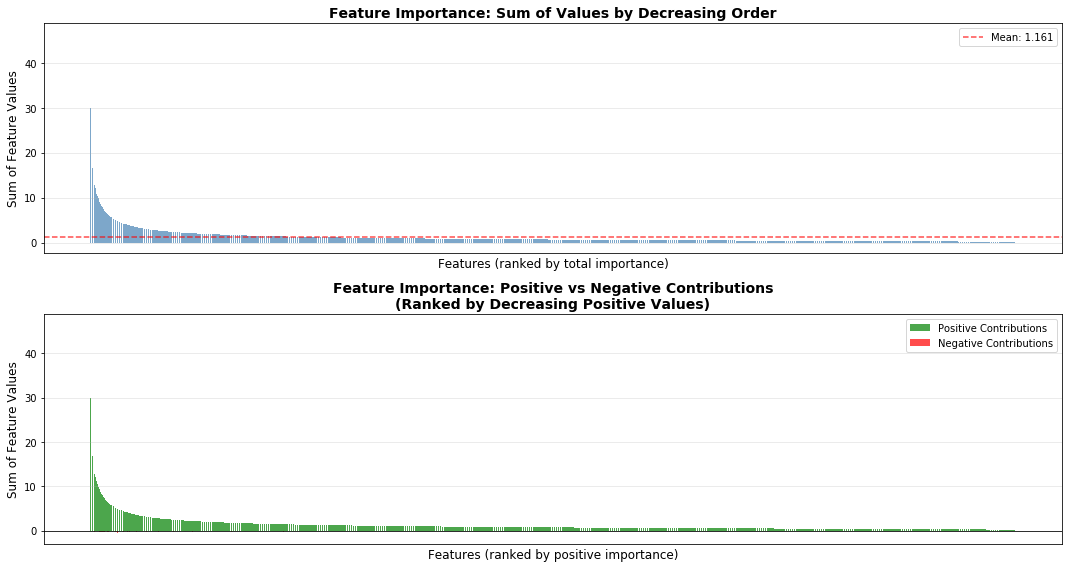


SUMMARY STATISTICS
Top 10 features by total importance:
feature_18042_diff    46.431678
feature_6049_diff     40.509097
feature_15302_diff    39.305724
feature_3070_diff     34.855112
feature_12440_diff    34.074335
feature_19441_diff    33.442429
feature_6251_diff     31.125915
feature_5459_diff     30.375266
feature_15805_diff    29.879331
feature_16831_diff    29.137779
dtype: float64

Top 10 features by positive contributions:
                               feature  positive_sum
feature_18042_diff   feature_8935_diff     46.463460
feature_6049_diff   feature_15496_diff     40.532533
feature_15302_diff   feature_5891_diff     39.336990
feature_3070_diff   feature_12187_diff     34.897965
feature_12440_diff   feature_2711_diff     34.172294
feature_19441_diff  feature_10489_diff     33.505872
feature_6251_diff   feature_15721_diff     31.179756
feature_5459_diff   feature_14840_diff     30.498958
feature_15805_diff   feature_6449_diff     29.946055
feature_16831_diff   feature_7589_

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the parquet file
df = pd.read_parquet('feature_importance.parquet')

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of samples: {df.shape[0]}")

# Calculate sum of column values (across all samples for each feature)
feature_sums = df.sum(axis=0).sort_values(ascending=False)

# Plot 1: Sum of column values by decreasing order
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
x_pos = range(len(feature_sums))
plt.bar(x_pos, feature_sums.values, alpha=0.7, color='steelblue')
plt.title('Feature Importance: Sum of Values by Decreasing Order', fontsize=14, fontweight='bold')
plt.xlabel('Features (ranked by total importance)', fontsize=12)
plt.ylabel('Sum of Feature Values', fontsize=12)
plt.xticks([]) # Hide x-axis labels since we have 20k features
plt.grid(axis='y', alpha=0.3)

# Add some statistics as text
mean_importance = feature_sums.mean()
plt.axhline(y=mean_importance, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_importance:.3f}')
plt.legend()

# Calculate positive and negative sums for each feature
positive_sums = df.where(df > 0, 0).sum(axis=0)
negative_sums = df.where(df < 0, 0).sum(axis=0)

# Create DataFrame for easier manipulation
importance_df = pd.DataFrame({
    'feature': df.columns,
    'positive_sum': positive_sums,
    'negative_sum': negative_sums,
    'total_sum': feature_sums
})

# Sort by positive sum in decreasing order
importance_df = importance_df.sort_values('positive_sum', ascending=False)

# Plot 2: Positive and negative sums separated by x-axis
plt.subplot(2, 1, 2)
x_pos = range(len(importance_df))

# Plot positive values above x-axis
plt.bar(x_pos, importance_df['positive_sum'].values, alpha=0.7, color='green', 
         label='Positive Contributions')

# Plot negative values below x-axis (negative values will automatically go below)
plt.bar(x_pos, importance_df['negative_sum'].values, alpha=0.7, color='red', 
         label='Negative Contributions')

plt.title('Feature Importance: Positive vs Negative Contributions\n(Ranked by Decreasing Positive Values)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Features (ranked by positive importance)', fontsize=12)
plt.ylabel('Sum of Feature Values', fontsize=12)
plt.xticks([]) # Hide x-axis labels since we have 20k features
plt.axhline(y=0, color='black', linewidth=0.8)
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Top 10 features by total importance:")
print(feature_sums.head(10))

print(f"\nTop 10 features by positive contributions:")
print(importance_df.head(10)[['feature', 'positive_sum']])

print(f"\nFeatures with highest negative contributions:")
print(importance_df.nsmallest(10, 'negative_sum')[['feature', 'negative_sum']])

print(f"\nOverall statistics:")
print(f"Total positive contributions: {importance_df['positive_sum'].sum():.3f}")
print(f"Total negative contributions: {importance_df['negative_sum'].sum():.3f}")
print(f"Net importance: {importance_df['total_sum'].sum():.3f}")
print(f"Number of features with positive contributions: {(importance_df['positive_sum'] > 0).sum()}")
print(f"Number of features with negative contributions: {(importance_df['negative_sum'] < 0).sum()}")

Dataset shape: (1736, 19887)


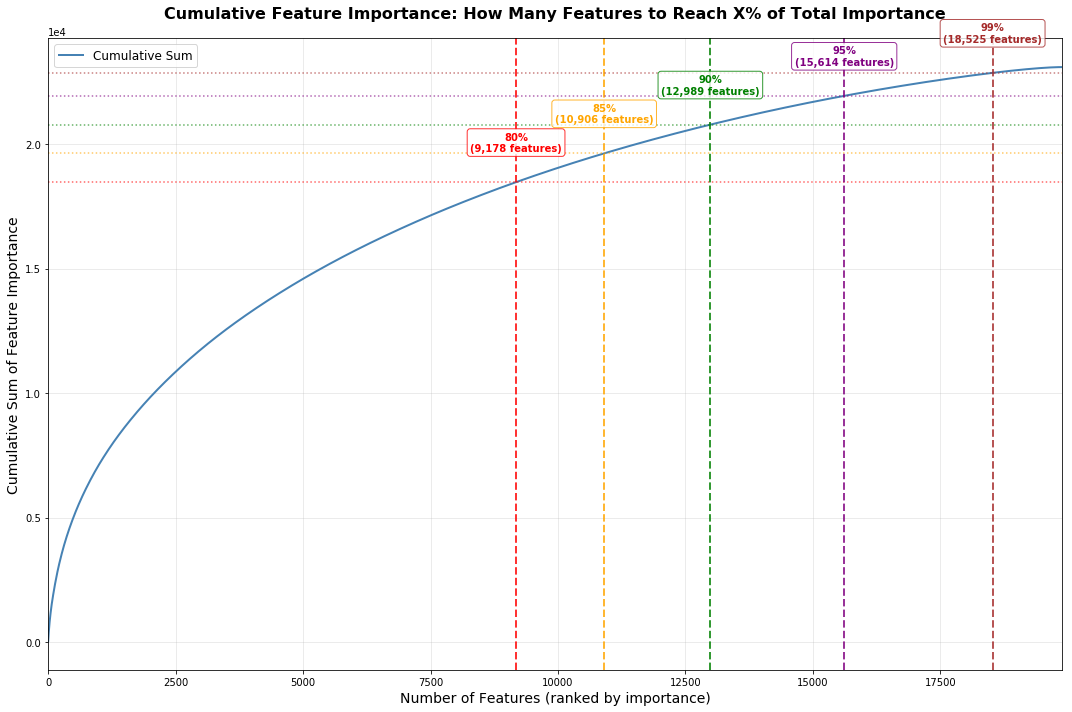


CUMULATIVE FEATURE IMPORTANCE ANALYSIS
Total sum of all feature importance: 23083.502844
Number of features: 19,887

Features needed to reach percentage thresholds:
--------------------------------------------------
80% of importance (18466.802275) → 9,178 features (46.15% of all features)
85% of importance (19620.977417) → 10,906 features (54.84% of all features)
90% of importance (20775.152559) → 12,989 features (65.31% of all features)
95% of importance (21929.327702) → 15,614 features (78.51% of all features)
99% of importance (22852.667815) → 18,525 features (93.15% of all features)

Top 20 most important features:
----------------------------------------
 1. feature_18042_diff:  46.431678 (cumulative:  0.20%)
 2. feature_6049_diff:  40.509097 (cumulative:  0.38%)
 3. feature_15302_diff:  39.305724 (cumulative:  0.55%)
 4. feature_3070_diff:  34.855112 (cumulative:  0.70%)
 5. feature_12440_diff:  34.074335 (cumulative:  0.85%)
 6. feature_19441_diff:  33.442429 (cumulative:  0.9

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the parquet file
df = pd.read_parquet('feature_importance.parquet')

print(f"Dataset shape: {df.shape}")

# Calculate sum of column values and sort by decreasing order
feature_sums = df.sum(axis=0).sort_values(ascending=False)
total_sum = feature_sums.sum()

# Calculate cumulative sum
cumulative_sums = feature_sums.cumsum()

# Calculate percentages for the markers
percentages = [80, 85, 90, 95, 99]
threshold_values = [total_sum * (p/100) for p in percentages]

# Find the number of features needed to reach each percentage
features_needed = []
for threshold in threshold_values:
    # Find first index where cumulative sum >= threshold
    idx = np.argmax(cumulative_sums.values >= threshold)
    features_needed.append(idx + 1)  # +1 because index is 0-based

# Create the plot
plt.figure(figsize=(15, 10))

# Plot cumulative sum
plt.plot(range(len(cumulative_sums)), cumulative_sums.values, 
         linewidth=2, color='steelblue', label='Cumulative Sum')

# Add vertical markers for each percentage
colors = ['red', 'orange', 'green', 'purple', 'brown']
for i, (pct, threshold, n_features) in enumerate(zip(percentages, threshold_values, features_needed)):
    plt.axvline(x=n_features-1, color=colors[i], linestyle='--', alpha=0.8, linewidth=2)
    plt.axhline(y=threshold, color=colors[i], linestyle=':', alpha=0.6)
    
    # Add text annotation
    plt.annotate(f'{pct}%\n({n_features:,} features)', 
                xy=(n_features-1, threshold), 
                xytext=(n_features-1, threshold + total_sum*0.05),
                ha='center', va='bottom',
                fontsize=10, fontweight='bold',
                color=colors[i],
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=colors[i]))

plt.title('Cumulative Feature Importance: How Many Features to Reach X% of Total Importance', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features (ranked by importance)', fontsize=14)
plt.ylabel('Cumulative Sum of Feature Importance', fontsize=14)
plt.grid(True, alpha=0.3)

# Format y-axis to show scientific notation if needed
if abs(total_sum) > 1000:
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Add legend
plt.legend(fontsize=12)

# Set x-axis limits to show the full range
plt.xlim(0, len(feature_sums))

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "="*80)
print("CUMULATIVE FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print(f"Total sum of all feature importance: {total_sum:.6f}")
print(f"Number of features: {len(feature_sums):,}")
print("\nFeatures needed to reach percentage thresholds:")
print("-" * 50)

for pct, n_features, threshold in zip(percentages, features_needed, threshold_values):
    percentage_of_features = (n_features / len(feature_sums)) * 100
    print(f"{pct:2d}% of importance ({threshold:10.6f}) → {n_features:5,} features ({percentage_of_features:5.2f}% of all features)")

print("\nTop 20 most important features:")
print("-" * 40)
for i, (feature, importance) in enumerate(feature_sums.head(20).items()):
    cumulative_pct = (cumulative_sums.iloc[i] / total_sum) * 100
    print(f"{i+1:2d}. {feature}: {importance:10.6f} (cumulative: {cumulative_pct:5.2f}%)")

# Additional insights
print(f"\nInsights:")
print(f"- Top 1% of features ({len(feature_sums)//100:,}) contribute {(cumulative_sums.iloc[len(feature_sums)//100-1]/total_sum)*100:.1f}% of total importance")
print(f"- Top 5% of features ({len(feature_sums)//20:,}) contribute {(cumulative_sums.iloc[len(feature_sums)//20-1]/total_sum)*100:.1f}% of total importance")
print(f"- Top 10% of features ({len(feature_sums)//10:,}) contribute {(cumulative_sums.iloc[len(feature_sums)//10-1]/total_sum)*100:.1f}% of total importance")

Dataset shape: (1736, 19887)


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


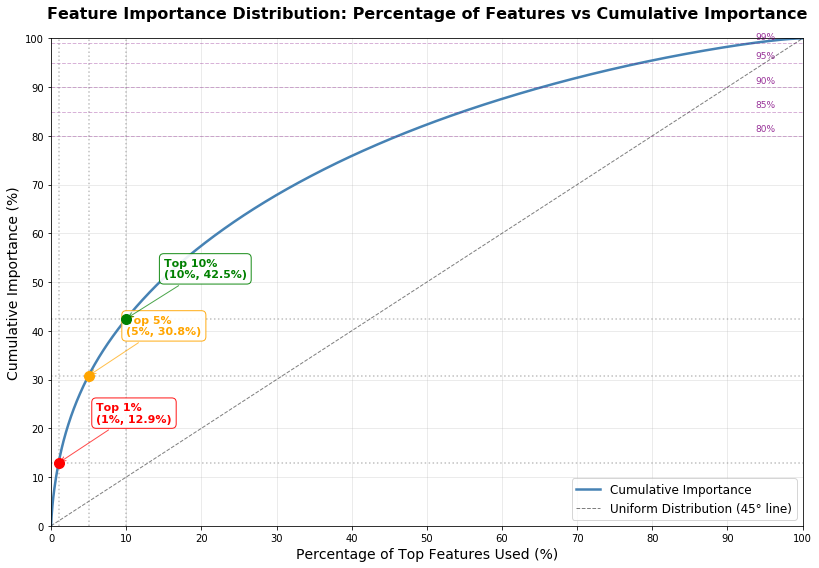


FEATURE IMPORTANCE CONCENTRATION ANALYSIS
Key percentages:
Top  1% of features contribute  12.9% of total importance
Top  5% of features contribute  30.8% of total importance
Top 10% of features contribute  42.5% of total importance
Top 20% of features contribute  57.5% of total importance
Top 50% of features contribute  82.3% of total importance

To reach key importance thresholds:
50% of importance requires  14.5% of features (2,874 features)
80% of importance requires  46.2% of features (9,177 features)
90% of importance requires  65.3% of features (12,989 features)
95% of importance requires  78.5% of features (15,614 features)
99% of importance requires  93.2% of features (18,525 features)

Feature importance Gini coefficient: -0.516
(0 = perfectly equal importance, 1 = maximum inequality)


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the parquet file
df = pd.read_parquet('feature_importance.parquet')

print(f"Dataset shape: {df.shape}")

# Calculate sum of column values and sort by decreasing order
feature_sums = df.sum(axis=0).sort_values(ascending=False)
total_sum = feature_sums.sum()
n_features = len(feature_sums)

# Calculate cumulative sum
cumulative_sums = feature_sums.cumsum()

# Convert to percentages
# X-axis: percentage of features used (0 to 100%)
feature_percentages = np.arange(1, n_features + 1) / n_features * 100

# Y-axis: cumulative importance as percentage of total
cumulative_percentages = cumulative_sums / total_sum * 100

# Create the plot
plt.figure(figsize=(12, 8))

# Plot the curve
plt.plot(feature_percentages, cumulative_percentages, 
         linewidth=2.5, color='steelblue', label='Cumulative Importance')

# Add diagonal line for reference (perfect uniform distribution)
plt.plot([0, 100], [0, 100], 'k--', alpha=0.5, linewidth=1, 
         label='Uniform Distribution (45° line)')

# Highlight specific points mentioned in your insights
highlight_points = [
    (1, 12.9, "Top 1%"),
    (5, 30.8, "Top 5%"), 
    (10, 42.5, "Top 10%")
]

colors = ['red', 'orange', 'green']
for i, (x_pct, y_pct, label) in enumerate(highlight_points):
    plt.scatter(x_pct, y_pct, color=colors[i], s=100, zorder=5)
    plt.annotate(f'{label}\n({x_pct}%, {y_pct}%)', 
                xy=(x_pct, y_pct), 
                xytext=(x_pct + 5, y_pct + 8),
                ha='left', va='bottom',
                fontsize=11, fontweight='bold',
                color=colors[i],
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                         alpha=0.9, edgecolor=colors[i]),
                arrowprops=dict(arrowstyle='->', color=colors[i], alpha=0.7))

# Add grid lines for the highlighted points
for x_pct, y_pct, _ in highlight_points:
    plt.axvline(x=x_pct, color='gray', linestyle=':', alpha=0.5)
    plt.axhline(y=y_pct, color='gray', linestyle=':', alpha=0.5)

# Add some additional reference lines
reference_lines = [80, 85, 90, 95, 99]
for ref_pct in reference_lines:
    # Find the percentage of features needed to reach this cumulative importance
    idx = np.argmax(cumulative_percentages >= ref_pct)
    features_pct_needed = feature_percentages[idx]
    
    plt.axhline(y=ref_pct, color='purple', linestyle='--', alpha=0.3, linewidth=1)
    plt.text(95, ref_pct + 0.5, f'{ref_pct}%', ha='center', va='bottom', 
             fontsize=9, color='purple', alpha=0.8)

plt.title('Feature Importance Distribution: Percentage of Features vs Cumulative Importance', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage of Top Features Used (%)', fontsize=14)
plt.ylabel('Cumulative Importance (%)', fontsize=14)

# Set axis limits and ticks
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 101, 10))

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\n" + "="*70)
print("FEATURE IMPORTANCE CONCENTRATION ANALYSIS")
print("="*70)

# Calculate some key statistics
print("Key percentages:")
key_percentages = [1, 5, 10, 20, 50]
for pct in key_percentages:
    idx = int(n_features * pct / 100) - 1  # -1 for 0-based indexing
    if idx < len(cumulative_percentages):
        cum_importance = cumulative_percentages[idx]
        print(f"Top {pct:2d}% of features contribute {cum_importance:5.1f}% of total importance")

print(f"\nTo reach key importance thresholds:")
importance_thresholds = [50, 80, 90, 95, 99]
for threshold in importance_thresholds:
    idx = np.argmax(cumulative_percentages >= threshold)
    features_pct = feature_percentages[idx]
    n_features_needed = int(n_features * features_pct / 100)
    print(f"{threshold:2d}% of importance requires {features_pct:5.1f}% of features ({n_features_needed:,} features)")

# Calculate Gini coefficient (measure of inequality)
# Perfect equality would be 0, maximum inequality would be 1
def gini_coefficient(x):
    """Calculate Gini coefficient for measuring inequality"""
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n

gini = gini_coefficient(feature_sums.values)
print(f"\nFeature importance Gini coefficient: {gini:.3f}")
print(f"(0 = perfectly equal importance, 1 = maximum inequality)")

In [18]:
import pandas as pd
import numpy as np
import json
import re

# Read the parquet file
df = pd.read_parquet('feature_importance.parquet')

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]}")

# Calculate sum of column values and sort by decreasing order
feature_sums = df.sum(axis=0).sort_values(ascending=False)

# Calculate how many features represent 5% of total features
n_features = len(feature_sums)
top_5_percent_count = int(np.ceil(n_features * 0.05))

print(f"Total number of features: {n_features:,}")
print(f"Top 5% represents: {top_5_percent_count:,} features")

# Get the top 5% most important features
top_5_percent_features = feature_sums.head(top_5_percent_count)

print(f"\nTop 10 features (as example):")
for i, (feature_name, importance) in enumerate(top_5_percent_features.head(10).items()):
    print(f"{i+1:2d}. {feature_name}: {importance:.6f}")

# Extract feature indexes from column names
# Pattern: 'feature_XXXXX_diff' -> extract XXXXX
feature_indexes = []
pattern = r'feature_(\d+)_diff'

for feature_name in top_5_percent_features.index:
    match = re.search(pattern, feature_name)
    if match:
        feature_index = int(match.group(1))
        feature_indexes.append(feature_index)
    else:
        print(f"Warning: Could not extract index from feature name: {feature_name}")

print(f"\nExtracted {len(feature_indexes)} feature indexes")
print(f"First 10 indexes: {feature_indexes[:10]}")
print(f"Index range: {min(feature_indexes)} to {max(feature_indexes)}")

# Save just the list to JSON file
output_filename = "top_5_percent_feature_indexes.json"
with open(output_filename, 'w') as f:
    json.dump(feature_indexes, f)

print(f"\n" + "="*60)
print(f"JSON file saved as: {output_filename}")
print(f"Contains {len(feature_indexes)} feature indexes (just the list)")

# Verify the output
print(f"\nVerification:")
print(f"- All indexes are integers: {all(isinstance(idx, int) for idx in feature_indexes)}")
print(f"- No duplicate indexes: {len(feature_indexes) == len(set(feature_indexes))}")
print(f"- Indexes correspond to top features: ✓")

# Show some examples of the mapping
print(f"\nExample feature name -> index mappings:")
for i, (feature_name, importance) in enumerate(top_5_percent_features.head(5).items()):
    extracted_idx = feature_indexes[i]
    print(f"'{feature_name}' -> {extracted_idx}")

Dataset shape: (1736, 19887)
Number of features: 19887
Total number of features: 19,887
Top 5% represents: 995 features

Top 10 features (as example):
 1. feature_18042_diff: 46.431678
 2. feature_6049_diff: 40.509097
 3. feature_15302_diff: 39.305724
 4. feature_3070_diff: 34.855112
 5. feature_12440_diff: 34.074335
 6. feature_19441_diff: 33.442429
 7. feature_6251_diff: 31.125915
 8. feature_5459_diff: 30.375266
 9. feature_15805_diff: 29.879331
10. feature_16831_diff: 29.137779

Extracted 995 feature indexes
First 10 indexes: [18042, 6049, 15302, 3070, 12440, 19441, 6251, 5459, 15805, 16831]
Index range: 3 to 19886

JSON file saved as: top_5_percent_feature_indexes.json
Contains 995 feature indexes (just the list)

Verification:
- All indexes are integers: True
- No duplicate indexes: True
- Indexes correspond to top features: ✓

Example feature name -> index mappings:
'feature_18042_diff' -> 18042
'feature_6049_diff' -> 6049
'feature_15302_diff' -> 15302
'feature_3070_diff' -> 307

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import gc
import json
from torch.cuda.amp import autocast, GradScaler

class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.dropout1 = nn.Dropout(0.02)
        self.fc2 = nn.Linear(2000, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.02)
        self.fc3 = nn.Linear(200, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.dropout3 = nn.Dropout(0.02)
        self.fc4 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.fc4(x))
        return x

class PyTorchOCSVM(nn.Module):
    def __init__(self, input_dim, nu=0.1, device='cuda:0'):
        super(PyTorchOCSVM, self).__init__()
        self.nu = nu
        self.device = device
        self.input_dim = input_dim
        
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)
        
    def forward(self, x):
        return self.feature_net(x)

class OptimizedGPUOCSVM:
    """GPU-native OSVM with adaptive batch sizing and conservative fp16 usage"""
    def __init__(self):
        self.model = None
        self.scaler_mean = None
        self.scaler_scale = None
        self.center = None
        self.rho = 0.0
        self.device = None
        self.batch_size = 1024
        
    def load_model(self, filepath):
        checkpoint = torch.load(filepath, map_location='cuda:0')
        
        self.nu = checkpoint['nu']
        self.rho = checkpoint['rho']
        self.center = checkpoint['center'].to('cuda:0') if checkpoint['center'] is not None else None
        self.device = 'cuda:0'
        
        # Keep scaler parameters in float32 for numerical stability
        scaler = checkpoint['scaler']
        self.scaler_mean = torch.tensor(scaler.mean_, dtype=torch.float32, device='cuda:0')
        self.scaler_scale = torch.tensor(scaler.scale_, dtype=torch.float32, device='cuda:0')
        
        input_dim = checkpoint['input_dim']
        self.model = PyTorchOCSVM(input_dim, self.nu, self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        # JIT compile for speed
        dummy_input = torch.randn(1, input_dim, device=self.device)
        self.model = torch.jit.trace(self.model, dummy_input)
        
        # Find optimal batch size for this hardware
        self.batch_size = self._find_optimal_batch_size(input_dim)
        
        print(f"OSVM model loaded, JIT compiled, optimal batch size: {self.batch_size}")
    
    def _find_optimal_batch_size(self, n_features):
        """Find optimal batch size based on available VRAM"""
        for batch_size in [2048, 1536, 1024, 768, 512, 256]:
            try:
                dummy = torch.randn(batch_size, n_features, device=self.device)
                with torch.no_grad():
                    batch_scaled = (dummy - self.scaler_mean) / self.scaler_scale
                    with autocast():
                        _ = self.model(batch_scaled)
                del dummy, batch_scaled
                torch.cuda.empty_cache()
                return batch_size
            except torch.cuda.OutOfMemoryError:
                continue
        
        return 128  # Conservative fallback
    
    def decision_function(self, X_tensor):
        """GPU-native decision function with mixed precision where safe"""
        decisions = torch.empty(len(X_tensor), device=self.device, dtype=torch.float32)
        
        with torch.no_grad():
            for i in range(0, len(X_tensor), self.batch_size):
                end_idx = min(i + self.batch_size, len(X_tensor))
                batch = X_tensor[i:end_idx]
                
                # Keep scaling in float32 for numerical stability
                batch_scaled = (batch - self.scaler_mean) / self.scaler_scale
                
                # Use mixed precision for forward pass only
                with autocast():
                    outputs = self.model(batch_scaled)
                
                # Distance calculation in float32 for precision
                distances = torch.sum((outputs.float() - self.center) ** 2, dim=1)
                decisions[i:end_idx] = -distances
        
        return decisions

def load_model(model_path, input_size, device):
    """Load and JIT compile MLP model"""
    model = MLP(input_size).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # JIT compile for speed
    dummy_input = torch.randn(1, input_size, device=device)
    model = torch.jit.trace(model, dummy_input)
    print("MLP model loaded and JIT compiled")
    
    return model

def compute_feature_ranges(X_eval, range_percent):
    """Compute feature ranges using GPU quantiles"""
    if range_percent < 0:
        lower_percentile = abs(range_percent)
        upper_percentile = 100 - abs(range_percent)
        min_vals = torch.quantile(X_eval, lower_percentile / 100.0, dim=0)
        max_vals = torch.quantile(X_eval, upper_percentile / 100.0, dim=0)
        print(f"Using percentile range: {lower_percentile}% to {upper_percentile}%")
    else:
        feature_min = X_eval.min(dim=0)[0]
        feature_max = X_eval.max(dim=0)[0]
        feature_range = (feature_max - feature_min) * (range_percent / 100)
        min_vals = feature_min - feature_range
        max_vals = feature_max + feature_range
        print(f"Using expanded range: ±{range_percent}% beyond observed min/max")
    
    return min_vals, max_vals

def warmup_models(mlp_model, osvm_model, n_features, device):
    """Pre-warm models to trigger CUDA kernel compilation"""
    print("Warming up models...")
    
    with torch.no_grad():
        warmup_data = torch.randn(64, n_features, device=device)
        
        with autocast():
            _ = mlp_model(warmup_data)
        
        _ = osvm_model.decision_function(warmup_data)
        
        del warmup_data
        torch.cuda.empty_cache()
    
    print("Model warmup completed")

def process_candidates_chunked(sample, first_feat_idx, second_feat_global_idx, 
                              first_samples, second_samples, mlp_model, osvm_model,
                              classification_weight, distance_weight, osvm_weight,
                              L1_NORM_MEAN, L1_NORM_STD, use_mixed_precision, 
                              chunk_size=1024):
    """Process candidates in memory-efficient chunks"""
    
    grid_first, grid_second = torch.meshgrid(first_samples, second_samples, indexing='ij')
    total_candidates = grid_first.numel()
    
    best_score = float('inf')
    best_pred = 0.0
    best_candidate = sample.clone()
    
    # Process in chunks to limit memory usage
    for chunk_start in range(0, total_candidates, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_candidates)
        chunk_size_actual = chunk_end - chunk_start
        
        # Create chunk candidates
        candidates_chunk = sample.unsqueeze(0).expand(chunk_size_actual, -1).contiguous()
        candidates_chunk[:, first_feat_idx] = grid_first.flatten()[chunk_start:chunk_end]
        candidates_chunk[:, second_feat_global_idx] = grid_second.flatten()[chunk_start:chunk_end]
        
        with torch.no_grad():
            # Process chunk
            if use_mixed_precision:
                with autocast():
                    chunk_preds = mlp_model(candidates_chunk).squeeze()
            else:
                chunk_preds = mlp_model(candidates_chunk).squeeze()
            
            if chunk_preds.dim() == 0:
                chunk_preds = chunk_preds.unsqueeze(0)
            
            chunk_osvm = osvm_model.decision_function(candidates_chunk)
            chunk_l1 = torch.sum(torch.abs(candidates_chunk - sample), dim=1)
            
            # Compute chunk scores
            chunk_scores = (chunk_preds * classification_weight + 
                           torch.abs(chunk_l1 - L1_NORM_MEAN) / L1_NORM_STD * distance_weight +
                           chunk_osvm * osvm_weight)
            
            # Update best from this chunk
            chunk_best_idx = torch.argmin(chunk_scores)
            chunk_best_score = chunk_scores[chunk_best_idx].item()
            
            if chunk_best_score < best_score:
                best_score = chunk_best_score
                best_pred = chunk_preds[chunk_best_idx].item()
                best_candidate = candidates_chunk[chunk_best_idx].clone()
        
        # Cleanup chunk
        del candidates_chunk, chunk_preds, chunk_osvm, chunk_l1, chunk_scores
    
    return best_score, best_pred, best_candidate

class ProgressTracker:
    """Comprehensive progress tracking with detailed statistics"""
    
    def __init__(self, total_samples, total_features, n_second_features, num_points_first, num_points_second):
        self.total_samples = total_samples
        self.total_features = total_features
        self.n_second_features = n_second_features
        self.num_points_first = num_points_first
        self.num_points_second = num_points_second
        
        # Calculate total work
        self.grid_size = num_points_first * num_points_second
        self.total_evaluations = total_samples * total_features * n_second_features * self.grid_size
        
        # Timing
        self.start_time = time.time()
        self.last_update_time = self.start_time
        self.update_interval = 20  # Update every 20 seconds
        
        # Progress counters
        self.completed_samples = 0
        self.completed_evaluations = 0
        
        # Speed tracking
        self.speed_history = []
        self.max_speed_history = 10
        
        self.print_startup_summary()
    
    def print_startup_summary(self):
        """Print comprehensive startup information"""
        print(f"\n{'='*85}")
        print(f"🚀 COUNTERFACTUAL GENERATION STARTED")
        print(f"{'='*85}")
        print(f"📊 Dataset Configuration:")
        print(f"   • Total samples: {self.total_samples:,}")
        print(f"   • Primary features: {self.total_features:,}")
        print(f"   • Secondary features: {self.n_second_features:,}")
        print(f"📊 Grid Configuration:")
        print(f"   • Primary grid points: {self.num_points_first}")
        print(f"   • Secondary grid points: {self.num_points_second}")
        print(f"   • Grid size per pair: {self.grid_size:,}")
        print(f"📊 Computation Scale:")
        print(f"   • Total evaluations: {self.total_evaluations:,}")
        print(f"   • Evaluations per sample: {self.total_evaluations // self.total_samples:,}")
        print(f"🕐 Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*85}\n")
    
    def update(self, sample_idx, feature_idx=None, force_update=False):
        """Update progress with detailed tracking"""
        current_time = time.time()
        
        # Update counters
        self.completed_samples = sample_idx + 1
        if feature_idx is not None:
            # Calculate completed evaluations based on current progress
            base_evaluations = sample_idx * self.total_features * self.n_second_features * self.grid_size
            current_feature_evaluations = feature_idx * self.n_second_features * self.grid_size
            self.completed_evaluations = base_evaluations + current_feature_evaluations
        else:
            # If no feature index, assume sample is complete
            self.completed_evaluations = self.completed_samples * self.total_features * self.n_second_features * self.grid_size
        
        # Check if we should update display
        should_update = (
            force_update or 
            (current_time - self.last_update_time >= self.update_interval) or
            sample_idx == 0 or
            sample_idx == self.total_samples - 1
        )
        
        if should_update:
            self.last_update_time = current_time
            self._display_progress(current_time)
    
    def _display_progress(self, current_time):
        """Display comprehensive progress information"""
        elapsed_time = current_time - self.start_time
        
        # Calculate progress percentage
        progress_pct = (self.completed_evaluations / self.total_evaluations) * 100 if self.total_evaluations > 0 else 0
        sample_progress_pct = (self.completed_samples / self.total_samples) * 100
        
        # Calculate speed metrics
        if elapsed_time > 0:
            current_speed = self.completed_evaluations / elapsed_time
            self.speed_history.append(current_speed)
            if len(self.speed_history) > self.max_speed_history:
                self.speed_history.pop(0)
            avg_speed = sum(self.speed_history) / len(self.speed_history)
        else:
            avg_speed = 0
        
        # Calculate ETA
        if avg_speed > 0:
            remaining_evaluations = self.total_evaluations - self.completed_evaluations
            eta_seconds = remaining_evaluations / avg_speed
            finish_time = datetime.now() + timedelta(seconds=eta_seconds)
        else:
            eta_seconds = 0
            finish_time = datetime.now()
        
        # Format time strings
        elapsed_str = self._format_duration(elapsed_time)
        eta_str = self._format_duration(eta_seconds)
        
        # Create progress bar
        bar_width = 40
        filled_width = int(bar_width * progress_pct / 100)
        bar = '█' * filled_width + '░' * (bar_width - filled_width)
        
        # Display progress
        print(f"\r{progress_pct:6.2f}% [{bar}] "
              f"Sample: {self.completed_samples:4d}/{self.total_samples} ({sample_progress_pct:5.1f}%) | "
              f"Elapsed: {elapsed_str} | ETA: {eta_str} | "
              f"Speed: {avg_speed:8,.0f} eval/s | "
              f"Finish: {finish_time.strftime('%m-%d %H:%M')}", end='', flush=True)
    
    def _format_duration(self, seconds):
        """Format duration in human readable format"""
        if seconds < 60:
            return f"{seconds:.0f}s"
        elif seconds < 3600:
            return f"{seconds/60:.1f}m"
        elif seconds < 86400:
            return f"{seconds/3600:.1f}h"
        else:
            return f"{seconds/86400:.1f}d"
    
    def finish(self):
        """Display final completion summary"""
        total_time = time.time() - self.start_time
        avg_speed = self.completed_evaluations / total_time if total_time > 0 else 0
        
        print(f"\n\n{'='*85}")
        print(f"✅ COUNTERFACTUAL GENERATION COMPLETED!")
        print(f"{'='*85}")
        print(f"📊 Final Statistics:")
        print(f"   • Total runtime: {self._format_duration(total_time)}")
        print(f"   • Evaluations completed: {self.completed_evaluations:,}")
        print(f"   • Samples processed: {self.completed_samples:,}")
        print(f"   • Average speed: {avg_speed:,.0f} evaluations/second")
        print(f"🏁 Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*85}\n")

def generate_2feature_counterfactuals_osvm_optimized(
    data_eval_path,
    model_path,
    osvm_model_path,
    second_feature_json_path,
    num_points_first=25,
    num_points_second=15,
    range_percent=-10,
    classification_weight=10.0,
    distance_weight=10.0,
    osvm_weight=10.0,
    gpu_id=0,
    use_mixed_precision=True,
    prediction_batch_size=2048,
    use_chunked_processing=True,
    chunk_size=1024,
    output_cf_path='best_counterfactuals_2feat_osvm.parquet',
    output_importance_path='feature_importance_2feat_osvm.parquet'
):
    """
    CORRECTED VERSION with comprehensive progress tracking
    Optimized counterfactual generation with conservative fp16 usage:
    - fp16 for large storage tensors (candidates, samples)
    - Mixed precision for model inference
    - fp32 for all distance calculations and final scoring
    """
    start_time = time.time()
    
    # GPU setup
    device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        print(f"Using device: {device} with RTX 2080 Ti optimizations")
    
    # Load data
    print("Loading evaluation data...")
    df_eval = pd.read_parquet(data_eval_path)
    X_eval = df_eval.iloc[:, 1:].values
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32, device=device)
    
    n_samples, n_features = X_eval_tensor.shape
    print(f"Data: {n_samples} samples, {n_features} features")
    
    # Load models
    print("Loading models...")
    mlp_model = load_model(model_path, n_features, device)
    osvm_model = OptimizedGPUOCSVM()
    osvm_model.load_model(osvm_model_path)
    
    warmup_models(mlp_model, osvm_model, n_features, device)
    
    # Load second feature indices
    print(f"Loading second feature indices...")
    try:
        with open(second_feature_json_path, 'r') as f:
            second_feature_indices = json.load(f)
        
        valid_indices = [idx for idx in second_feature_indices 
                        if isinstance(idx, int) and 0 <= idx < n_features]
        second_feature_indices = torch.tensor(valid_indices, device=device, dtype=torch.long)
        
        if len(second_feature_indices) == 0:
            print("Error: No valid second feature indices found")
            return None, None
            
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading JSON: {e}")
        return None, None
    
    n_second_features = len(second_feature_indices)
    print(f"Loaded {n_second_features} second feature indices")
    
    # Compute feature ranges
    print("Computing feature ranges...")
    min_vals, max_vals = compute_feature_ranges(X_eval_tensor, range_percent)
    
    # Pre-allocate sampling tensors
    print("Pre-allocating sampling points...")
    first_feature_samples = torch.empty(n_features, num_points_first, device=device, dtype=torch.float16)
    for i in range(n_features):
        first_feature_samples[i] = torch.linspace(min_vals[i], max_vals[i], num_points_first, device=device, dtype=torch.float16)
    
    second_feature_samples = torch.empty(n_second_features, num_points_second, device=device, dtype=torch.float16)
    for i, idx in enumerate(second_feature_indices):
        second_feature_samples[i] = torch.linspace(min_vals[idx], max_vals[idx], num_points_second, device=device, dtype=torch.float16)
    
    # Get initial predictions
    print("Computing initial predictions...")
    initial_predictions = torch.zeros(n_samples, device=device, dtype=torch.float32)
    
    with torch.no_grad():
        for i in range(0, n_samples, prediction_batch_size):
            end_i = min(i + prediction_batch_size, n_samples)
            if use_mixed_precision:
                with autocast():
                    batch_pred = mlp_model(X_eval_tensor[i:end_i]).squeeze()
            else:
                batch_pred = mlp_model(X_eval_tensor[i:end_i]).squeeze()
            
            if batch_pred.dim() == 0:
                batch_pred = batch_pred.unsqueeze(0)
            initial_predictions[i:end_i] = batch_pred
    
    # Initialize progress tracker
    progress_tracker = ProgressTracker(
        total_samples=n_samples,
        total_features=n_features,
        n_second_features=n_second_features,
        num_points_first=num_points_first,
        num_points_second=num_points_second
    )
    
    # MAIN PROCESSING LOOP
    print("Starting counterfactual generation...\n")
    
    L1_NORM_MEAN = 6471.3016
    L1_NORM_STD = 1596.4753
    
    best_counterfactuals = []
    feature_importance_data = []
    
    # Process each sample
    for sample_idx in range(n_samples):
        # Keep sample in fp32 during processing for numerical stability
        sample = X_eval_tensor[sample_idx]
        initial_pred = initial_predictions[sample_idx]
        
        best_sample_score = float('inf')
        best_sample_classification = initial_pred.item()
        best_sample_candidate = sample.clone()
        sample_feature_importance = torch.zeros(n_features, device=device, dtype=torch.float32)
        
        # Process each first feature
        for first_feat_idx in range(n_features):
            first_samples = first_feature_samples[first_feat_idx].float()
            
            best_feature_score = float('inf')
            best_feature_pred = initial_pred.item()
            best_feature_candidate = sample.clone()
            
            # Process each second feature
            for second_feat_idx, second_feat_global_idx in enumerate(second_feature_indices):
                second_samples = second_feature_samples[second_feat_idx].float()
                
                # Use chunked processing or vectorized approach
                if use_chunked_processing:
                    score, pred, candidate = process_candidates_chunked(
                        sample, first_feat_idx, second_feat_global_idx,
                        first_samples, second_samples, mlp_model, osvm_model,
                        classification_weight, distance_weight, osvm_weight,
                        L1_NORM_MEAN, L1_NORM_STD, use_mixed_precision,
                        chunk_size
                    )
                else:
                    # Vectorized approach (faster but uses more memory)
                    grid_first, grid_second = torch.meshgrid(first_samples, second_samples, indexing='ij')
                    n_candidates = grid_first.numel()
                    
                    candidates = sample.unsqueeze(0).expand(n_candidates, -1).contiguous()
                    candidates[:, first_feat_idx] = grid_first.flatten()
                    candidates[:, second_feat_global_idx] = grid_second.flatten()
                    
                    with torch.no_grad():
                        if use_mixed_precision:
                            with autocast():
                                mlp_predictions = mlp_model(candidates).squeeze()
                        else:
                            mlp_predictions = mlp_model(candidates).squeeze()
                        
                        if mlp_predictions.dim() == 0:
                            mlp_predictions = mlp_predictions.unsqueeze(0)
                        
                        osvm_scores = osvm_model.decision_function(candidates)
                        l1_distances = torch.sum(torch.abs(candidates - sample), dim=1)
                        
                        classification_component = mlp_predictions * classification_weight
                        distance_component = torch.abs(l1_distances - L1_NORM_MEAN) / L1_NORM_STD * distance_weight
                        osvm_component = osvm_scores * osvm_weight
                        
                        total_scores = classification_component + distance_component + osvm_component
                        
                        best_idx = torch.argmin(total_scores)
                        score = total_scores[best_idx].item()
                        pred = mlp_predictions[best_idx].item()
                        candidate = candidates[best_idx]
                    
                    # Memory cleanup
                    del candidates, mlp_predictions, osvm_scores, l1_distances
                    del classification_component, distance_component, osvm_component, total_scores
                
                # Update best for this first feature
                if score < best_feature_score:
                    best_feature_score = score
                    best_feature_pred = pred
                    best_feature_candidate = candidate
            
            # Update feature importance
            sample_feature_importance[first_feat_idx] = initial_pred - best_feature_pred
            
            # Update global best for this sample
            if best_feature_score < best_sample_score:
                best_sample_score = best_feature_score
                best_sample_classification = best_feature_pred
                best_sample_candidate = best_feature_candidate
            
            # Update progress tracker
            progress_tracker.update(sample_idx, first_feat_idx)
            
            # Periodic cleanup
            if (first_feat_idx + 1) % 200 == 0:
                torch.cuda.empty_cache()
        
        # Store results after processing all features for this sample
        cf_row = [best_sample_classification] + best_sample_candidate.cpu().numpy().tolist()
        best_counterfactuals.append(cf_row)
        
        importance_row = sample_feature_importance.cpu().numpy().tolist()
        feature_importance_data.append(importance_row)
        
        # Update progress tracker (sample complete)
        progress_tracker.update(sample_idx)
        
        # Memory cleanup after each sample
        if (sample_idx + 1) % 20 == 0:
            gc.collect()
            torch.cuda.empty_cache()
    
    # Finish progress tracking
    progress_tracker.finish()
    
    # Save results
    print("Saving results...")
    cf_columns = ['classification'] + [f'feature_{i}' for i in range(n_features)]
    importance_columns = [f'feature_{i}_diff' for i in range(n_features)]
    
    best_cf_df = pd.DataFrame(best_counterfactuals, columns=cf_columns)
    importance_df = pd.DataFrame(feature_importance_data, columns=importance_columns)
    
    best_cf_df.to_parquet(output_cf_path, engine='pyarrow', compression='snappy', index=False)
    importance_df.to_parquet(output_importance_path, engine='pyarrow', compression='snappy', index=False)
    
    print(f"✅ Saved counterfactuals: {output_cf_path}")
    print(f"✅ Saved feature importance: {output_importance_path}")
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return best_cf_df, importance_df



best_cfs2dim, feature_importance2dim = generate_2feature_counterfactuals_osvm_optimized(
    data_eval_path='data_eval_norm100.parquet',
    model_path='mlp_model.pth',
    osvm_model_path='OSVM_TCGA_class0_20kfeatures_gpu2.pkl',
    second_feature_json_path='top_2_percent_feature_indexes.json',
    num_points_first=4,
    num_points_second=6,
    range_percent=-15,
    classification_weight=10.0,
    distance_weight=10.0,
    osvm_weight=10.0,
    gpu_id=0,
    use_mixed_precision=True,
    prediction_batch_size=2048,
    use_chunked_processing=True,  # Set to True for maximum memory efficiency
    chunk_size=1024
)

if best_cfs is not None:
    print(f"\nSuccess! Generated {len(best_cfs)} counterfactuals")
    print(f"Feature importance shape: {feature_importance.shape}")
else:
    print("Generation failed - check error messages above")

Using device: cuda:0 with RTX 2080 Ti optimizations
Loading evaluation data...
Data: 100 samples, 19887 features
Loading models...
MLP model loaded and JIT compiled
OSVM model loaded, JIT compiled, optimal batch size: 2048
Warming up models...
Model warmup completed
Loading second feature indices...
Loaded 398 second feature indices
Computing feature ranges...
Using percentile range: 15% to 85%
Pre-allocating sampling points...
Computing initial predictions...

🚀 COUNTERFACTUAL GENERATION STARTED
📊 Dataset Configuration:
   • Total samples: 100
   • Primary features: 19,887
   • Secondary features: 398
📊 Grid Configuration:
   • Primary grid points: 4
   • Secondary grid points: 6
   • Grid size per pair: 24
📊 Computation Scale:
   • Total evaluations: 18,996,062,400
   • Evaluations per sample: 189,960,624
🕐 Started at: 2025-07-10 13:51:56

Starting counterfactual generation...

 40.53% [████████████████░░░░░░░░░░░░░░░░░░░░░░░░] Sample:   41/100 ( 41.0%) | Elapsed: 6.0d | ETA: 8.8d | 